<a href="https://colab.research.google.com/github/Lianasy/Deep-learning-labs/blob/main/DL_lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Train set size: 800
Validation set size: 100
Test set size: 100


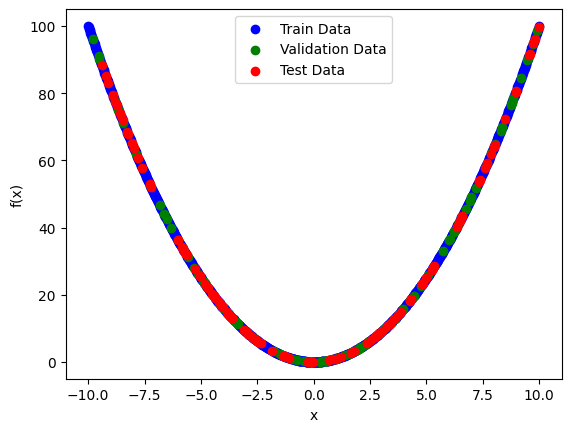

In [ ]:
from sklearn.model_selection import train_test_split
import torch
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
torch.manual_seed(42)

# Generate dataset for f(x) = x^2
x = np.linspace(-10, 10, 1000).reshape(-1, 1)  # 100 points from -2 to 2
y = x**2  # Compute f(x) = x^2

# Convert to PyTorch tensors
x_tensor = torch.tensor(x, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

# Split into Train (80%), Validation (10%), Test (10%)
X_train, X_temp, y_train, y_temp = train_test_split(x_tensor, y_tensor, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Print dataset sizes
print(f"Train set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")

# Plot the data
plt.scatter(X_train, y_train, label="Train Data", color="blue")
plt.scatter(X_val, y_val, label="Validation Data", color="green")
plt.scatter(X_test, y_test, label="Test Data", color="red")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend()
plt.show()



In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FeedforwardNN(nn.Module):
    def __init__(self, input_size=1, hidden_size=10, output_size=1, num_hidden_layers=1, activation_fn=nn.ReLU()):
        super(FeedforwardNN, self).__init__()

        # Create a list of hidden layers
        self.hidden_layers = nn.ModuleList()

        # First hidden layer (input to first hidden)
        self.hidden_layers.append(nn.Linear(input_size, hidden_size))

        # Additional hidden layers (if num_hidden_layers > 1)
        for _ in range(num_hidden_layers - 1):
            self.hidden_layers.append(nn.Linear(hidden_size, hidden_size))

        # Output layer (last hidden to output)
        self.output_layer = nn.Linear(hidden_size, output_size)

        # Activation function
        self.activation = activation_fn


    def forward(self, x):
        # Pass input through hidden layers with activation
        for layer in self.hidden_layers:
            x = self.activation(layer(x))

        # Final output layer (no activation for regression)
        x = self.output_layer(x)
        return x

In [ ]:
import torch.optim as optim

def train_model(model, X_train, y_train, X_val, y_val, epochs=1000, learning_rate=0.01, patience=50, optimizer_type="Adam"):
    """
    Trains the neural network model using the specified optimizer and applies early stopping.
    """

    # Select optimizer based on user input
    if optimizer_type == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    elif optimizer_type == "SGD":
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    elif optimizer_type == "RMSprop":
        optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)
    else:
        raise ValueError("Invalid optimizer selected")

    loss_function = nn.MSELoss()  # Mean Squared Error (MSE) loss function
    loss_history = []
    val_loss_history = []

    best_val_loss = float('inf')  # Track the best validation loss
    patience_counter = 0  # Counter for early stopping

    for epoch in range(epochs):

        # Forward pass: compute model predictions
        y_pred = model(X_train)
        loss = loss_function(y_pred, y_train)

        # Check for NaN values in training loss
        if torch.isnan(loss).any():
            print(f"NaN detected in training loss at epoch {epoch}. Stopping training.")
            break

        # Backpropagation: compute gradients
        optimizer.zero_grad()
        loss.backward()

        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # Update weights
        optimizer.step()

        # Validation phase
        with torch.no_grad():
            val_pred = model(X_val)
            val_loss = loss_function(val_pred, y_val)

            # Check for NaN values in validation loss
            if torch.isnan(val_loss).any():
                print(f"NaN detected in validation loss at epoch {epoch}. Stopping training.")
                break

        # Store loss values
        loss_history.append(loss.item())
        val_loss_history.append(val_loss.item())

        # Early stopping: check if validation loss improves
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0  # Reset patience counter
        else:
            patience_counter += 1  # Increase counter if no improvement

        # Stop training if patience limit is reached
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

        # Print loss every 100 epochs for tracking
        if epoch % 100 == 0:
            print(f"Epoch {epoch} → Train Loss: {loss.item():.6f}, Val Loss: {val_loss.item():.6f}")

    # Plot loss curves
    plt.figure(figsize=(8, 5))
    plt.plot(loss_history, label="Train Loss")
    plt.plot(val_loss_history, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.show()

    return loss_history, val_loss_history


In [ ]:
def plot_predictions(model, X_test, y_test):
    """
    Plots model predictions vs ground truth.
    """
    with torch.no_grad():
        y_pred = model(X_test).numpy()

    sorted_indices = np.argsort(X_test.numpy().flatten())
    X_test_sorted = X_test.numpy().flatten()[sorted_indices]
    y_pred_sorted = y_pred.flatten()[sorted_indices]
    y_test_sorted = y_test.numpy().flatten()[sorted_indices]

    plt.figure(figsize=(8, 5))

    plt.plot(X_test_sorted, y_test_sorted, label="Ground Truth", color="green", linestyle="dashed")

    plt.plot(X_test_sorted, y_pred_sorted, label="Model Prediction", color="red")

    plt.xlabel("x")
    plt.ylabel("f(x)")
    plt.title("Model Predictions vs Ground Truth")
    plt.legend()
    plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def evaluate_model(model, X_test, y_test):
    with torch.no_grad():
        y_pred = model(X_test).numpy()
        y_true = y_test.numpy()

    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"Mean Squared Error (MSE): {mse:.6f}")
    print(f"Mean Absolute Error (MAE): {mae:.6f}")
    print(f"R² Score: {r2:.6f}")

    return mse, mae, r2



🔹 Training model with 1 hidden layers and 4 neurons per layer 🔹
Epoch 0 → Train Loss: 1953.007080, Val Loss: 1739.627197
Epoch 100 → Train Loss: 640.580566, Val Loss: 497.340393
Epoch 200 → Train Loss: 140.097458, Val Loss: 137.689972
Epoch 300 → Train Loss: 70.644005, Val Loss: 66.907509
Epoch 400 → Train Loss: 34.977264, Val Loss: 33.195145
Epoch 500 → Train Loss: 16.822844, Val Loss: 14.760619
Epoch 600 → Train Loss: 10.036730, Val Loss: 7.056705
Epoch 700 → Train Loss: 7.564003, Val Loss: 5.243594
Epoch 800 → Train Loss: 6.909338, Val Loss: 4.994836
Early stopping at epoch 861


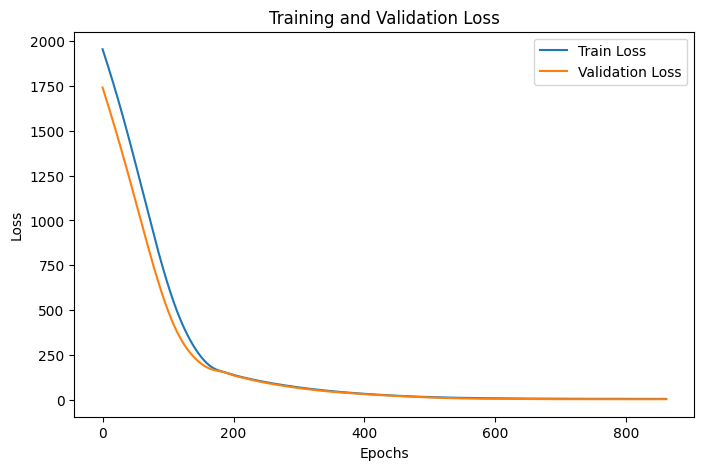

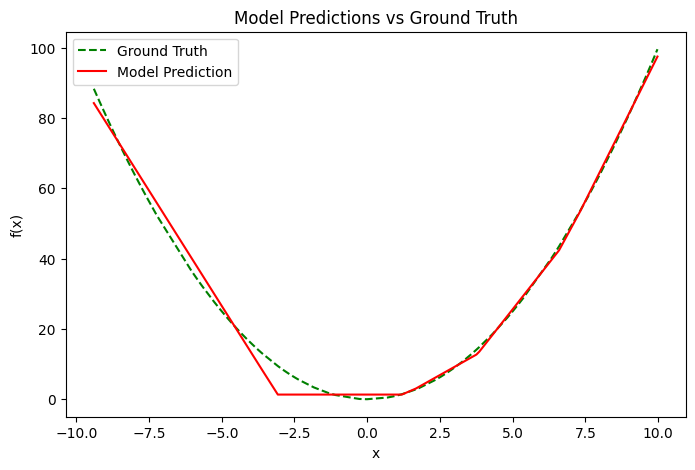

Mean Squared Error (MSE): 6.090476
Mean Absolute Error (MAE): 1.699951
R² Score: 0.992950

🔹 Training model with 1 hidden layers and 8 neurons per layer 🔹
Epoch 0 → Train Loss: 1949.165283, Val Loss: 1717.951294
Epoch 100 → Train Loss: 404.050964, Val Loss: 302.409729
Epoch 200 → Train Loss: 96.736893, Val Loss: 91.315453
Epoch 300 → Train Loss: 41.614822, Val Loss: 39.083309
Epoch 400 → Train Loss: 16.936663, Val Loss: 15.475507
Epoch 500 → Train Loss: 5.488239, Val Loss: 4.345657
Epoch 600 → Train Loss: 2.321440, Val Loss: 1.661803
Epoch 700 → Train Loss: 1.235772, Val Loss: 0.850342
Epoch 800 → Train Loss: 0.898038, Val Loss: 0.671294
Epoch 900 → Train Loss: 0.822648, Val Loss: 0.653715
Early stopping at epoch 933


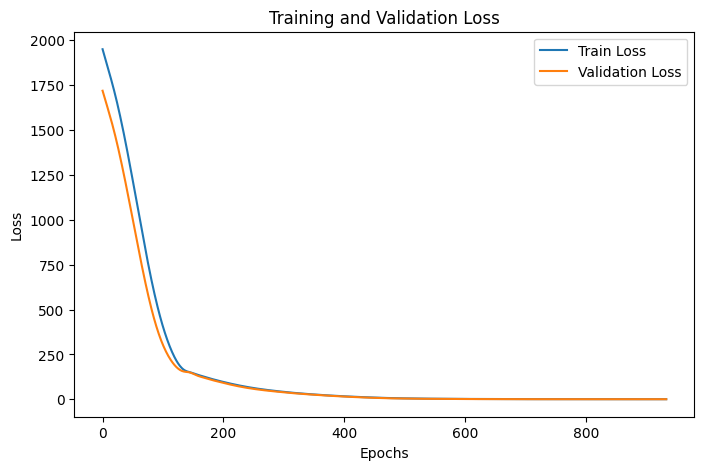

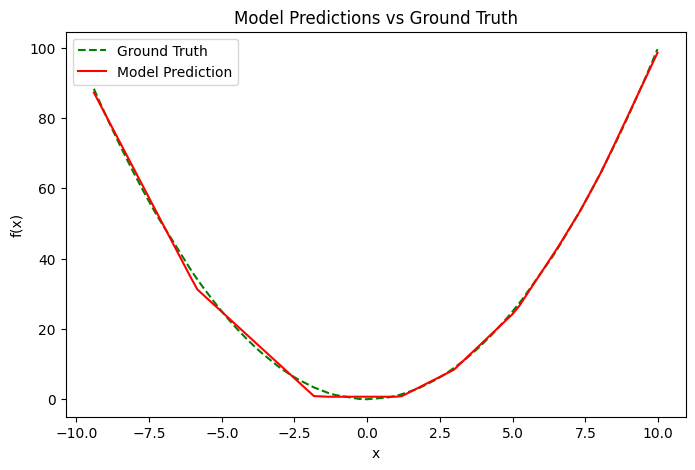

Mean Squared Error (MSE): 0.847521
Mean Absolute Error (MAE): 0.680242
R² Score: 0.999019

🔹 Training model with 1 hidden layers and 16 neurons per layer 🔹
Epoch 0 → Train Loss: 2056.754639, Val Loss: 1840.952026
Epoch 100 → Train Loss: 135.332047, Val Loss: 134.719086
Epoch 200 → Train Loss: 30.341639, Val Loss: 28.280146
Epoch 300 → Train Loss: 2.106615, Val Loss: 1.742029
Epoch 400 → Train Loss: 0.402617, Val Loss: 0.388964
Epoch 500 → Train Loss: 0.143280, Val Loss: 0.153736
Epoch 600 → Train Loss: 0.176638, Val Loss: 0.169087
Early stopping at epoch 639


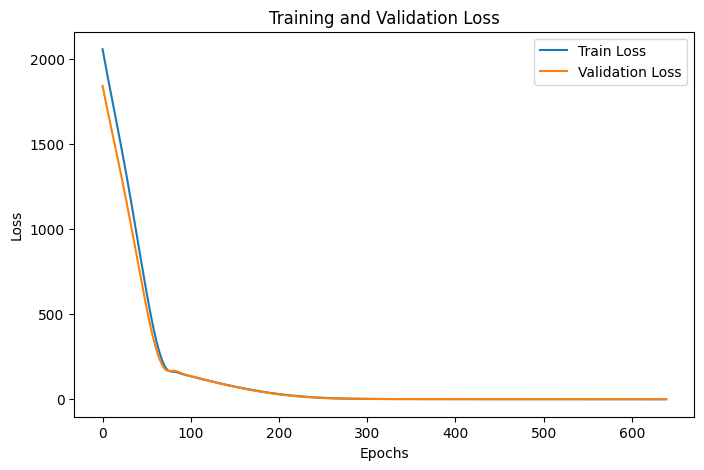

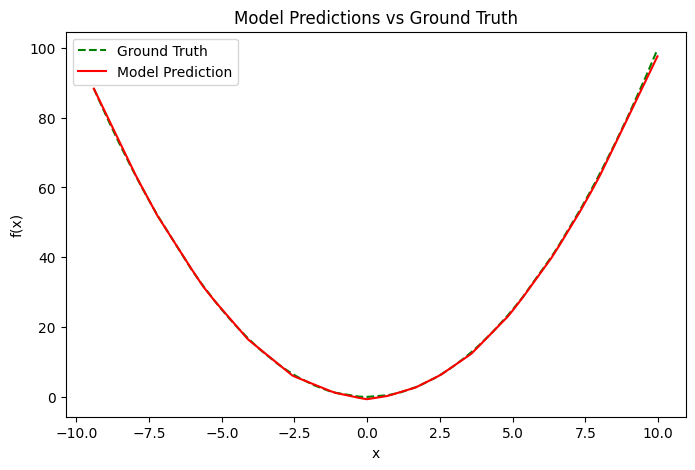

Mean Squared Error (MSE): 0.189079
Mean Absolute Error (MAE): 0.280389
R² Score: 0.999781

🔹 Training model with 1 hidden layers and 32 neurons per layer 🔹
Epoch 0 → Train Loss: 1999.164062, Val Loss: 1748.050903
Epoch 100 → Train Loss: 87.723495, Val Loss: 90.006340
Epoch 200 → Train Loss: 8.516582, Val Loss: 8.744111
Epoch 300 → Train Loss: 0.806648, Val Loss: 0.842674
Epoch 400 → Train Loss: 0.209229, Val Loss: 0.219647
Epoch 500 → Train Loss: 0.086305, Val Loss: 0.094023
Epoch 600 → Train Loss: 0.126469, Val Loss: 0.061463
Early stopping at epoch 630


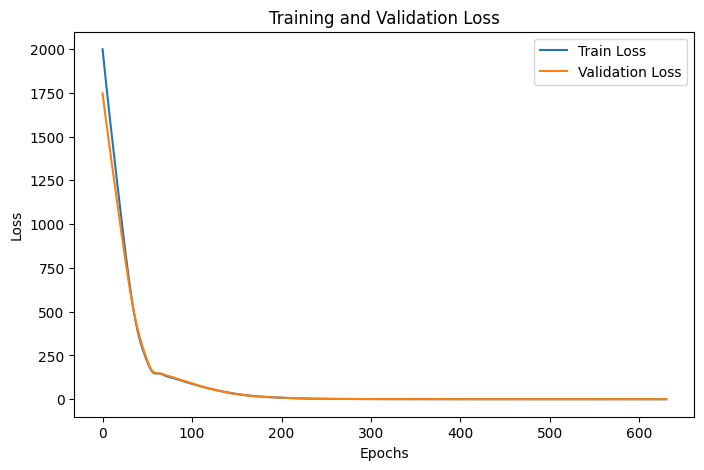

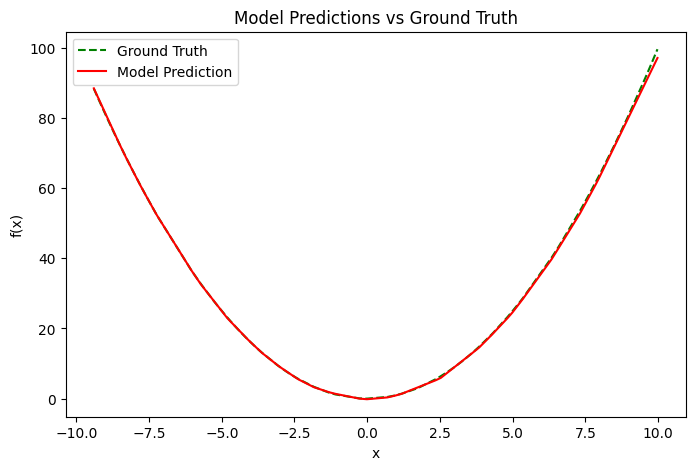

Mean Squared Error (MSE): 0.247799
Mean Absolute Error (MAE): 0.263448
R² Score: 0.999713

🔹 Training model with 1 hidden layers and 64 neurons per layer 🔹
Epoch 0 → Train Loss: 2144.649414, Val Loss: 1845.661621
Epoch 100 → Train Loss: 36.184845, Val Loss: 33.713943
Epoch 200 → Train Loss: 0.506113, Val Loss: 0.464634
Epoch 300 → Train Loss: 0.217397, Val Loss: 0.284523
Epoch 400 → Train Loss: 0.165126, Val Loss: 0.172528
Epoch 500 → Train Loss: 0.118312, Val Loss: 0.093040
Epoch 600 → Train Loss: 0.055266, Val Loss: 0.040917
Epoch 700 → Train Loss: 0.040542, Val Loss: 0.028798
Epoch 800 → Train Loss: 0.038568, Val Loss: 0.025535
Epoch 900 → Train Loss: 0.089361, Val Loss: 0.088267
Early stopping at epoch 948


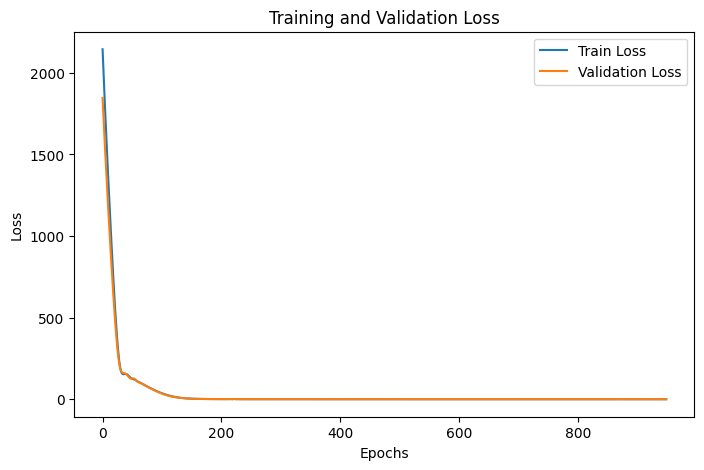

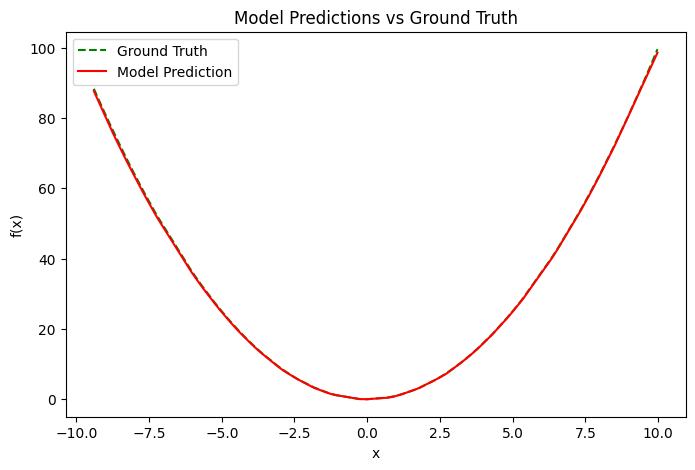

Mean Squared Error (MSE): 0.103302
Mean Absolute Error (MAE): 0.231432
R² Score: 0.999880

🔹 Training model with 2 hidden layers and 4 neurons per layer 🔹
Epoch 0 → Train Loss: 2033.378418, Val Loss: 1819.372803
Epoch 100 → Train Loss: 1943.543945, Val Loss: 1742.747803
Epoch 200 → Train Loss: 1879.062500, Val Loss: 1684.446777
Epoch 300 → Train Loss: 1816.951416, Val Loss: 1628.479736
Epoch 400 → Train Loss: 1756.992554, Val Loss: 1574.650757
Epoch 500 → Train Loss: 1699.116821, Val Loss: 1522.897339
Epoch 600 → Train Loss: 1643.293945, Val Loss: 1473.192505
Epoch 700 → Train Loss: 1589.507446, Val Loss: 1425.520508
Epoch 800 → Train Loss: 1537.746826, Val Loss: 1379.872559
Epoch 900 → Train Loss: 1488.006226, Val Loss: 1336.242554
Epoch 1000 → Train Loss: 1440.280640, Val Loss: 1294.626465
Epoch 1100 → Train Loss: 1394.567383, Val Loss: 1255.021240
Epoch 1200 → Train Loss: 1350.863647, Val Loss: 1217.425293
Epoch 1300 → Train Loss: 1309.167725, Val Loss: 1181.836304
Epoch 1400 → Trai

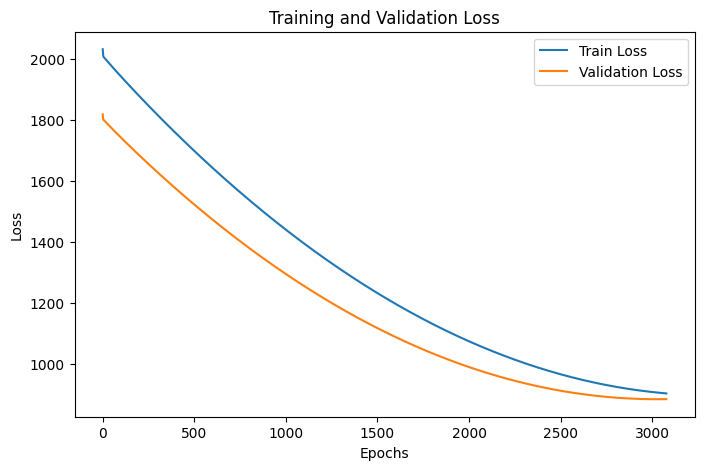

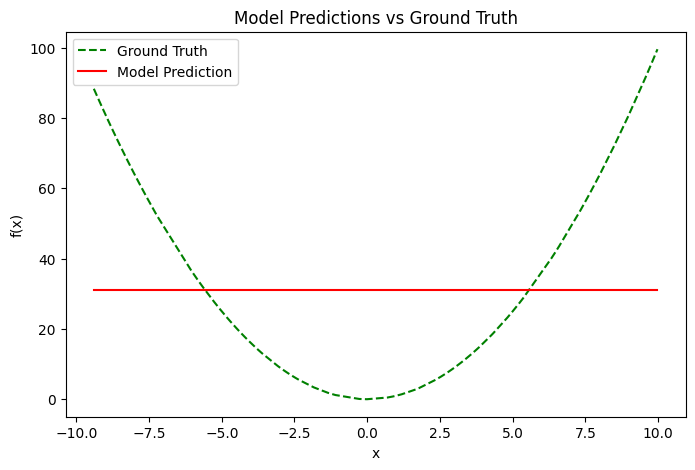

Mean Squared Error (MSE): 880.319580
Mean Absolute Error (MAE): 25.082386
R² Score: -0.019011

🔹 Training model with 2 hidden layers and 8 neurons per layer 🔹
Epoch 0 → Train Loss: 1983.639404, Val Loss: 1763.620605
Epoch 100 → Train Loss: 109.661713, Val Loss: 106.343216
Epoch 200 → Train Loss: 3.385625, Val Loss: 2.975981
Epoch 300 → Train Loss: 0.627172, Val Loss: 0.665350
Epoch 400 → Train Loss: 0.421565, Val Loss: 0.500191
Epoch 500 → Train Loss: 0.337798, Val Loss: 0.765880
Epoch 600 → Train Loss: 0.515890, Val Loss: 0.443593
Epoch 700 → Train Loss: 0.253589, Val Loss: 0.332920
Epoch 800 → Train Loss: 0.229528, Val Loss: 0.293891
Epoch 900 → Train Loss: 0.212256, Val Loss: 0.254889
Epoch 1000 → Train Loss: 0.197728, Val Loss: 0.234375
Epoch 1100 → Train Loss: 0.304810, Val Loss: 0.308138
Epoch 1200 → Train Loss: 0.274935, Val Loss: 0.228602
Early stopping at epoch 1253


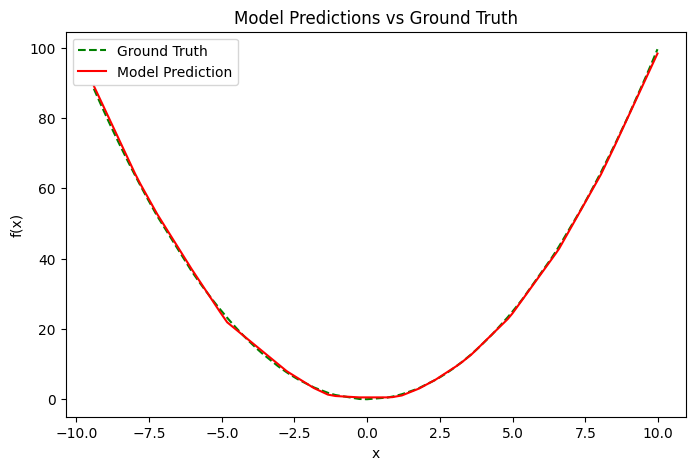

Mean Squared Error (MSE): 0.313515
Mean Absolute Error (MAE): 0.453269
R² Score: 0.999637

🔹 Training model with 2 hidden layers and 16 neurons per layer 🔹
Epoch 0 → Train Loss: 2016.941040, Val Loss: 1781.023438
Epoch 100 → Train Loss: 61.819893, Val Loss: 62.910717
Epoch 200 → Train Loss: 1.211594, Val Loss: 1.304458
Epoch 300 → Train Loss: 0.399597, Val Loss: 0.705312
Epoch 400 → Train Loss: 0.168677, Val Loss: 0.177466
Epoch 500 → Train Loss: 0.186250, Val Loss: 0.136666
Epoch 600 → Train Loss: 0.119299, Val Loss: 0.083646
Epoch 700 → Train Loss: 0.087587, Val Loss: 0.059833
Epoch 800 → Train Loss: 0.097433, Val Loss: 0.061149
Epoch 900 → Train Loss: 0.087060, Val Loss: 0.088171
Early stopping at epoch 921


Mean Squared Error (MSE): 0.061319
Mean Absolute Error (MAE): 0.145834
R² Score: 0.999929

🔹 Training model with 2 hidden layers and 32 neurons per layer 🔹
Epoch 0 → Train Loss: 2011.492188, Val Loss: 1734.662476
Epoch 100 → Train Loss: 12.825480, Val Loss: 11.292328
Epoch 200 → Train Loss: 0.756374, Val Loss: 0.427700
Epoch 300 → Train Loss: 0.206881, Val Loss: 0.206474
Epoch 400 → Train Loss: 0.158949, Val Loss: 0.096188
Epoch 500 → Train Loss: 0.361561, Val Loss: 0.536922
Early stopping at epoch 508


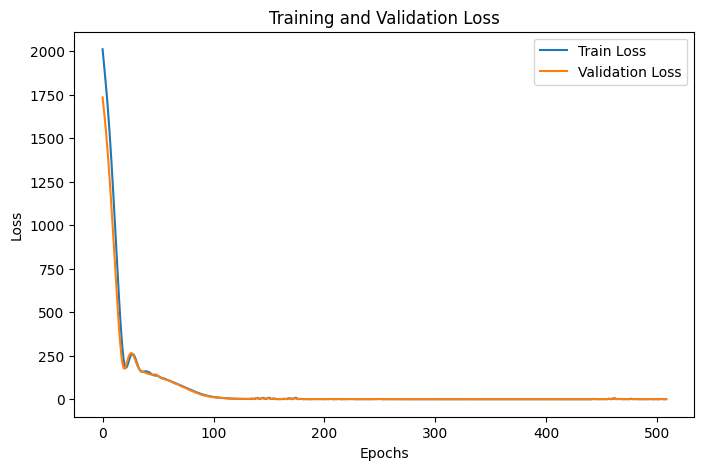

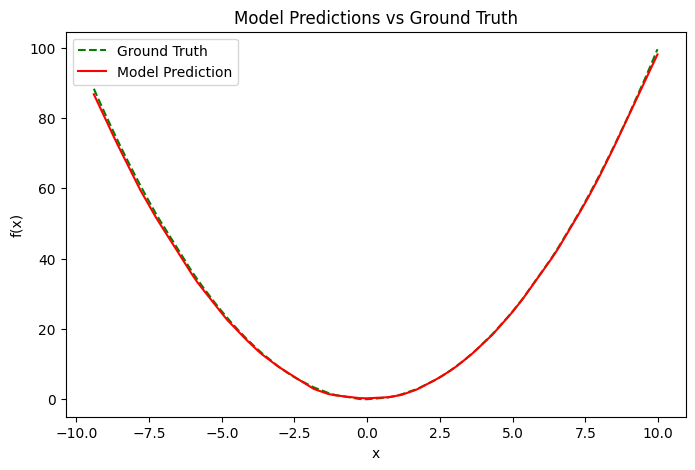

Mean Squared Error (MSE): 0.394908
Mean Absolute Error (MAE): 0.445309
R² Score: 0.999543

🔹 Training model with 2 hidden layers and 64 neurons per layer 🔹
Epoch 0 → Train Loss: 1989.111694, Val Loss: 1664.639526
Epoch 100 → Train Loss: 1.038547, Val Loss: 1.034338
Epoch 200 → Train Loss: 1.350430, Val Loss: 0.485564
Early stopping at epoch 226


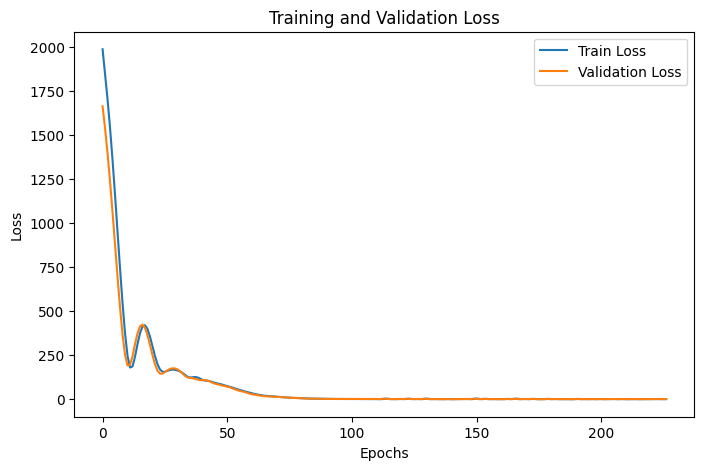

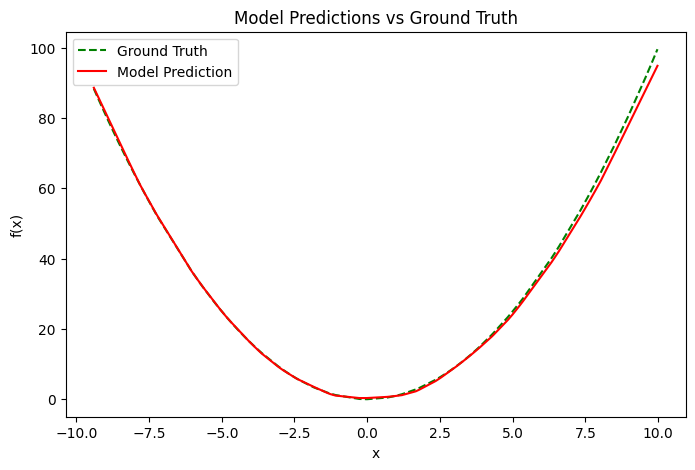

Mean Squared Error (MSE): 1.508494
Mean Absolute Error (MAE): 0.690866
R² Score: 0.998254

🔹 Training model with 3 hidden layers and 4 neurons per layer 🔹
Epoch 0 → Train Loss: 2032.124512, Val Loss: 1823.206055
Epoch 100 → Train Loss: 1796.834229, Val Loss: 1608.200806
Epoch 200 → Train Loss: 1368.387817, Val Loss: 1228.529785
Epoch 300 → Train Loss: 953.356567, Val Loss: 902.400940
Early stopping at epoch 376


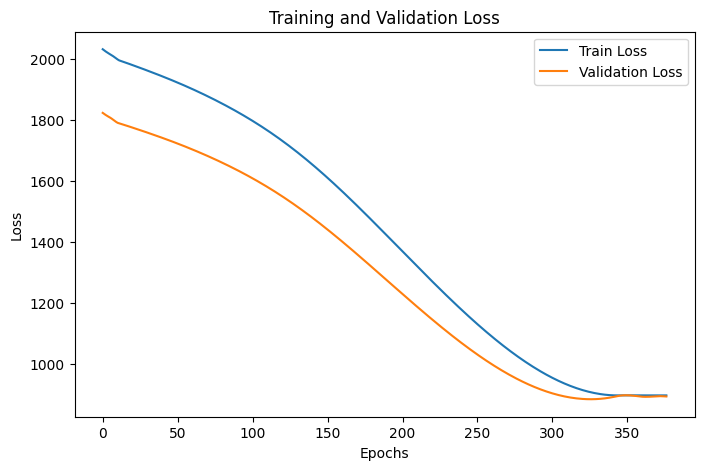

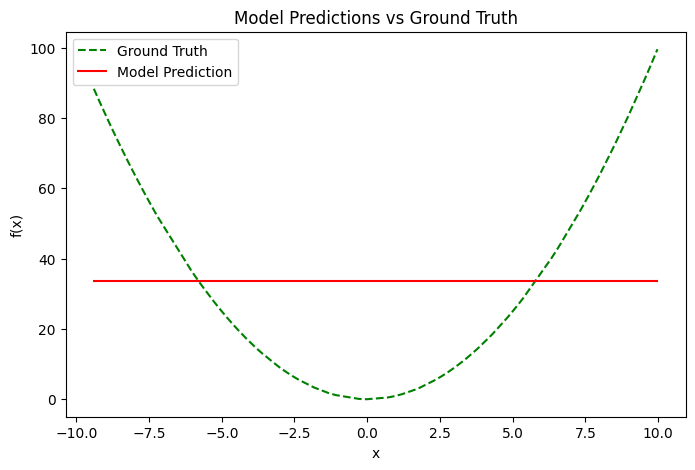

Mean Squared Error (MSE): 866.263977
Mean Absolute Error (MAE): 25.453257
R² Score: -0.002741

🔹 Training model with 3 hidden layers and 8 neurons per layer 🔹
Epoch 0 → Train Loss: 2046.168945, Val Loss: 1820.762329
Epoch 100 → Train Loss: 78.937080, Val Loss: 77.200027
Epoch 200 → Train Loss: 4.232283, Val Loss: 4.466760
Epoch 300 → Train Loss: 0.818810, Val Loss: 1.023365
Epoch 400 → Train Loss: 0.393227, Val Loss: 0.509584
Epoch 500 → Train Loss: 0.315628, Val Loss: 0.430527
Epoch 600 → Train Loss: 0.393380, Val Loss: 0.233739
Epoch 700 → Train Loss: 0.171768, Val Loss: 0.262677
Epoch 800 → Train Loss: 0.211223, Val Loss: 0.267153
Early stopping at epoch 827


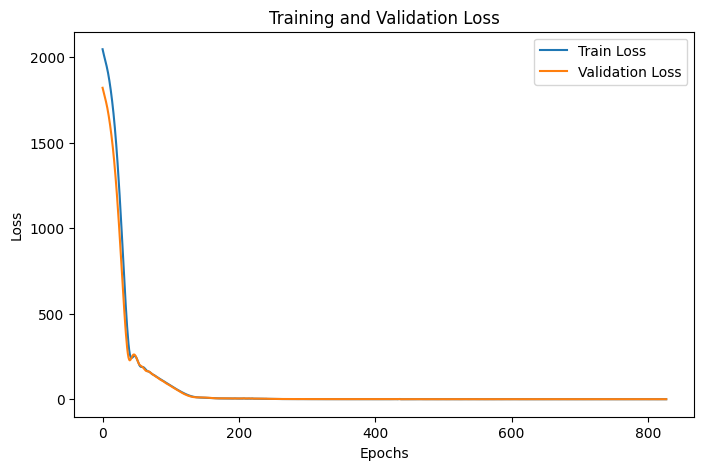

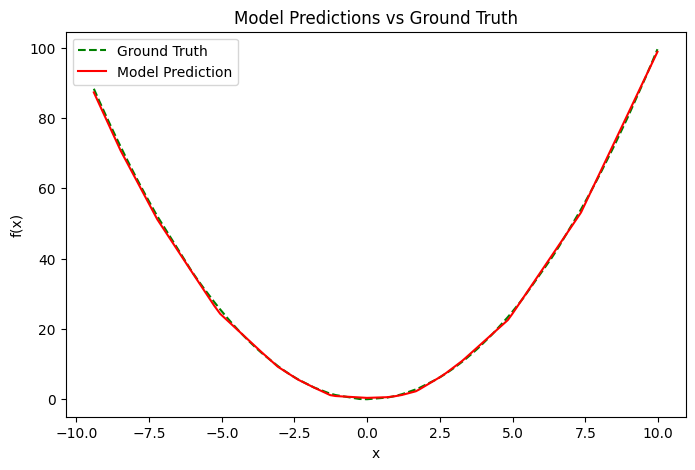

Mean Squared Error (MSE): 0.291960
Mean Absolute Error (MAE): 0.424581
R² Score: 0.999662

🔹 Training model with 3 hidden layers and 16 neurons per layer 🔹
Epoch 0 → Train Loss: 1995.123169, Val Loss: 1767.321411
Epoch 100 → Train Loss: 8.935503, Val Loss: 8.093267
Epoch 200 → Train Loss: 0.810023, Val Loss: 0.864570
Epoch 300 → Train Loss: 0.260655, Val Loss: 0.279740
Epoch 400 → Train Loss: 0.101893, Val Loss: 0.273590
Epoch 500 → Train Loss: 0.288644, Val Loss: 0.317312
Early stopping at epoch 522


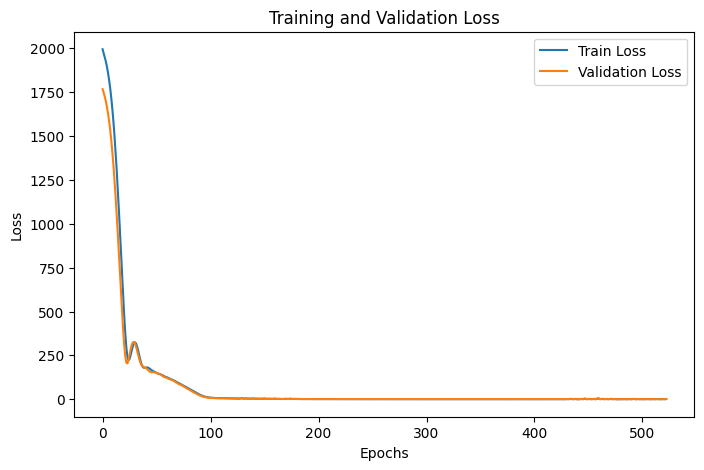

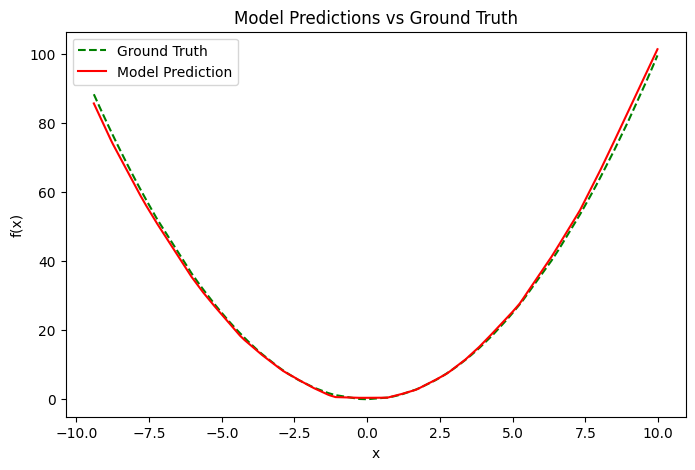

Mean Squared Error (MSE): 1.748460
Mean Absolute Error (MAE): 0.978009
R² Score: 0.997976

🔹 Training model with 3 hidden layers and 32 neurons per layer 🔹
Epoch 0 → Train Loss: 2027.049561, Val Loss: 1772.079712
Epoch 100 → Train Loss: 3.143077, Val Loss: 2.327302
Epoch 200 → Train Loss: 0.513156, Val Loss: 0.405380
Early stopping at epoch 230


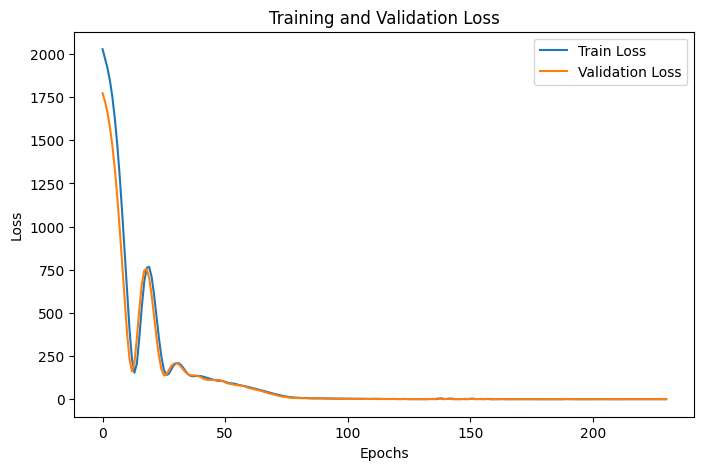

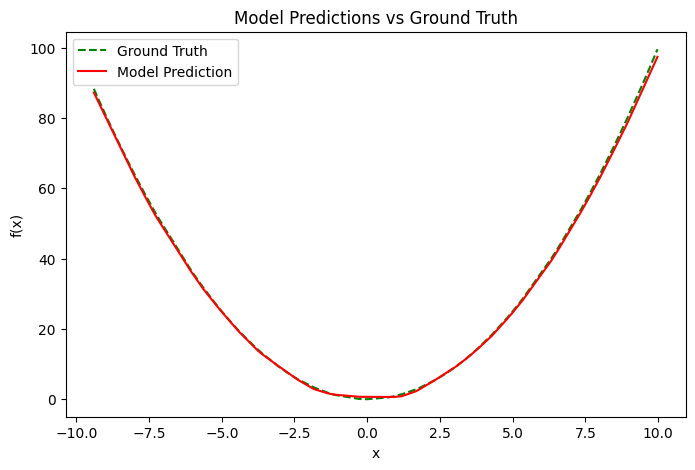

Mean Squared Error (MSE): 0.402466
Mean Absolute Error (MAE): 0.461072
R² Score: 0.999534

🔹 Training model with 3 hidden layers and 64 neurons per layer 🔹
Epoch 0 → Train Loss: 1999.579712, Val Loss: 1698.121826
Epoch 100 → Train Loss: 2.250130, Val Loss: 1.461179
Epoch 200 → Train Loss: 1.584855, Val Loss: 0.495282
Early stopping at epoch 207


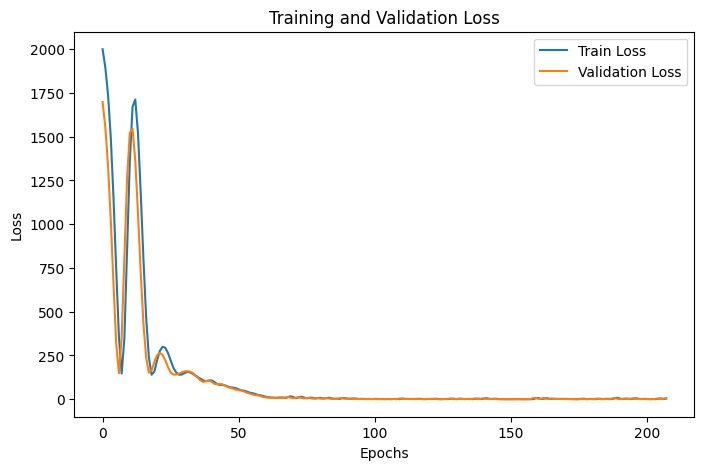

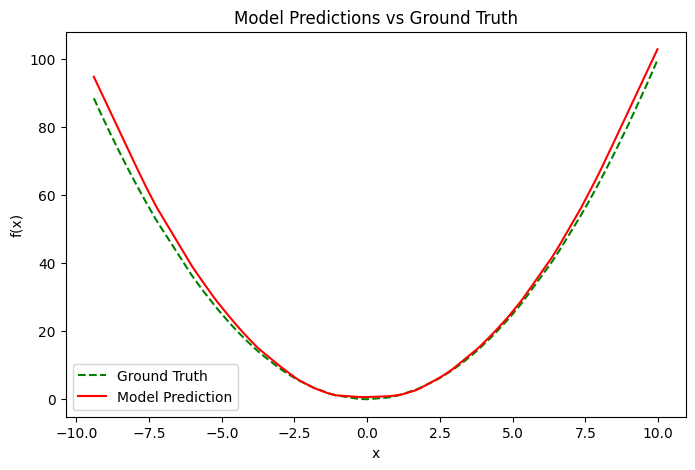

Mean Squared Error (MSE): 8.474964
Mean Absolute Error (MAE): 2.111401
R² Score: 0.990190


In [ ]:
import pandas as pd
# Define architectures to test
architectures = [
    {"hidden_size": 4, "num_layers": 1},
    {"hidden_size": 8, "num_layers": 1},
    {"hidden_size": 16, "num_layers": 1},
    {"hidden_size": 32, "num_layers": 1},
    {"hidden_size": 64, "num_layers": 1},
    {"hidden_size": 4, "num_layers": 2},
    {"hidden_size": 8, "num_layers": 2},
    {"hidden_size": 16, "num_layers": 2},
    {"hidden_size": 32, "num_layers": 2},
    {"hidden_size": 64, "num_layers": 2},
    {"hidden_size": 4, "num_layers": 3},
    {"hidden_size": 8, "num_layers": 3},
    {"hidden_size": 16, "num_layers": 3},
    {"hidden_size": 32, "num_layers": 3},
    {"hidden_size": 64, "num_layers": 3},
]


# Store results in a list
results = []

# Train and evaluate different architectures
for arch in architectures:
    print(f"\n🔹 Training model with {arch['num_layers']} hidden layers and {arch['hidden_size']} neurons per layer 🔹")

    # Create model with given parameters
    model = FeedforwardNN(hidden_size=arch["hidden_size"], num_hidden_layers=arch["num_layers"])

    # Train model with Early Stopping and return loss history
    loss_history, val_loss_history = train_model(model, X_train, y_train, X_val, y_val, epochs=10000, learning_rate=0.01, patience=50)

    plot_predictions(model, X_test, y_test)

    # Evaluate model performance
    mse, mae, r2 = evaluate_model(model, X_test, y_test)

    # Store results
    results.append({
        "Hidden Layers": arch["num_layers"],
        "Neurons per Layer": arch["hidden_size"],
        "Final Train Loss": loss_history[-1],
        "Final Validation Loss": val_loss_history[-1],
        "MSE": mse,
        "MAE": mae,
        "R² Score": r2
    })

# Convert results to Pandas DataFrame
df_results = pd.DataFrame(results)



In [ ]:
df_results

Hidden Layers  Neurons per Layer  Final Train Loss  Final Validation Loss  \
0               1                  4          6.683251               5.028357   
1               1                  8          0.832228               0.668680   
2               1                 16          0.108037               0.170025   
3               1                 32          0.095676               0.194045   
4               1                 64          0.066019               0.077429   
5               2                  4        902.304871             883.442139   
6               2                  8          0.172909               0.252170   
7               2                 16          0.805706               0.055014   
8               2                 32          0.954477               0.309951   
9               2                 64          0.675255               1.436033   
10              3                  4        895.764832             892.244202   
11              3                  8          0.210604               0.284079   
12              3                 16          0.951082               1.667233   
13              3                 32          0.436702               0.465164   
14              3                 64          3.860309               6.099303   

           MSE        MAE  R² Score  
0     6.090476   1.699951  0.992950  
1     0.847521   0.680242  0.999019  
2     0.189079   0.280389  0.999781  
3     0.247799   0.263448  0.999713  
4     0.103302   0.231432  0.999880  
5   880.319580  25.082386 -0.019011  
6     0.313515   0.453269  0.999637  
7     0.061319   0.145834  0.999929  
8     0.394908   0.445309  0.999543  
9     1.508494   0.690866  0.998254  
10  866.263977  25.453257 -0.002741  
11    0.291960   0.424581  0.999662  
12    1.748460   0.978009  0.997976  
13    0.402466   0.461072  0.999534  
14    8.474964   2.111401  0.990190


 Training model with Activation: ReLU, Optimizer: Adam
Epoch 0 → Train Loss: 1895.720947, Val Loss: 1675.040894
Epoch 100 → Train Loss: 83.337494, Val Loss: 82.972488
Epoch 200 → Train Loss: 4.575247, Val Loss: 4.159288
Epoch 300 → Train Loss: 0.359493, Val Loss: 0.337151
Epoch 400 → Train Loss: 0.091565, Val Loss: 0.086451
Epoch 500 → Train Loss: 0.164753, Val Loss: 0.072112
Early stopping at epoch 502


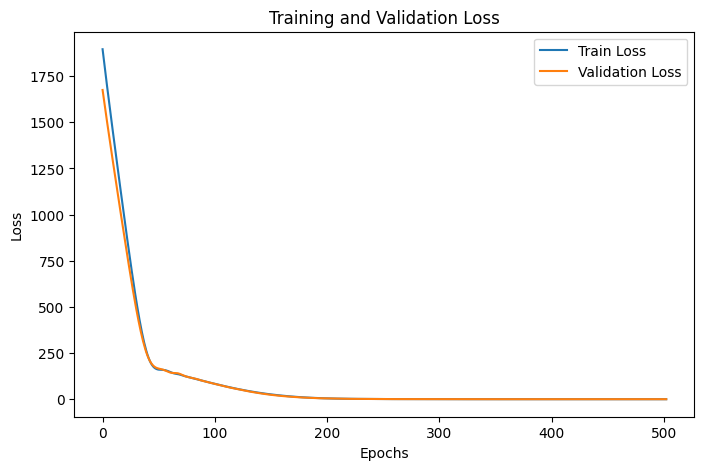

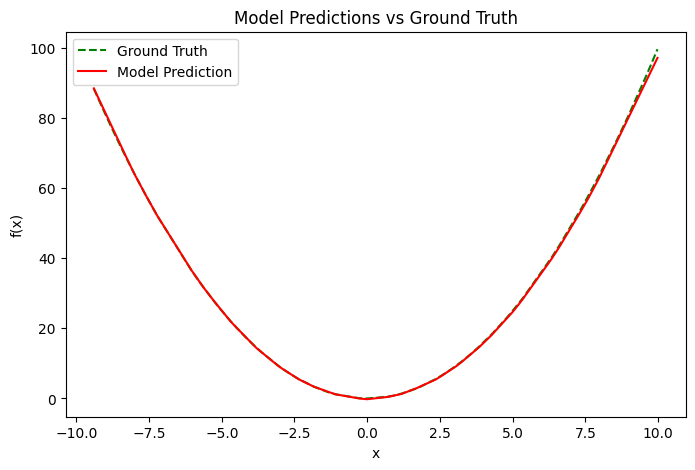

Mean Squared Error (MSE): 0.249799
Mean Absolute Error (MAE): 0.270847
R² Score: 0.999711

 Training model with Activation: Tanh, Optimizer: Adam
Epoch 0 → Train Loss: 2031.535889, Val Loss: 1818.915283
Epoch 100 → Train Loss: 972.573303, Val Loss: 912.235596
Epoch 200 → Train Loss: 376.974152, Val Loss: 394.996277
Epoch 300 → Train Loss: 182.679352, Val Loss: 200.758865
Epoch 400 → Train Loss: 96.593414, Val Loss: 109.449043
Epoch 500 → Train Loss: 49.412342, Val Loss: 56.557999
Epoch 600 → Train Loss: 23.105146, Val Loss: 26.000723
Epoch 700 → Train Loss: 4.768159, Val Loss: 5.231606
Epoch 800 → Train Loss: 1.640711, Val Loss: 1.761445
Epoch 900 → Train Loss: 0.835279, Val Loss: 0.868311
Epoch 1000 → Train Loss: 0.638307, Val Loss: 0.657448
Epoch 1100 → Train Loss: 0.538322, Val Loss: 0.537645
Epoch 1200 → Train Loss: 0.413427, Val Loss: 0.423002
Epoch 1300 → Train Loss: 0.336791, Val Loss: 0.339497
Epoch 1400 → Train Loss: 0.275542, Val Loss: 0.276654
Epoch 1500 → Train Loss: 0.2273

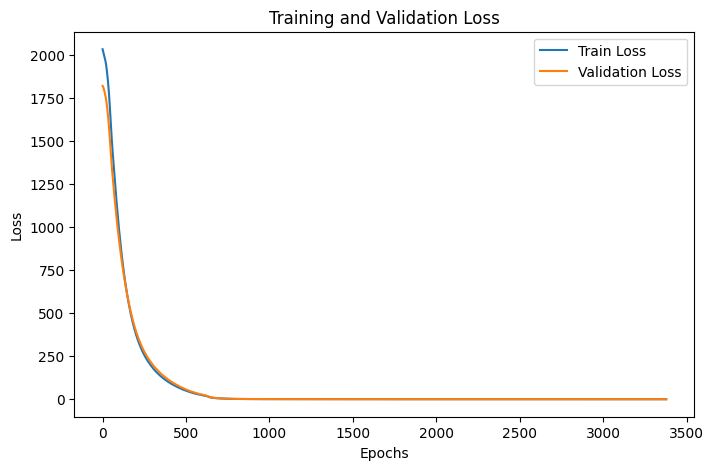

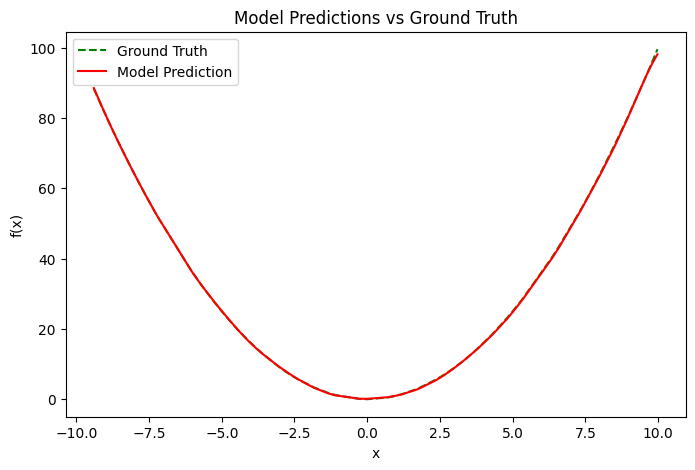

Mean Squared Error (MSE): 0.040602
Mean Absolute Error (MAE): 0.120554
R² Score: 0.999953

 Training model with Activation: Sigmoid, Optimizer: Adam
Epoch 0 → Train Loss: 1977.723022, Val Loss: 1762.711914
Epoch 100 → Train Loss: 956.574707, Val Loss: 881.119690
Epoch 200 → Train Loss: 639.657593, Val Loss: 630.584351
Epoch 300 → Train Loss: 479.167114, Val Loss: 468.434296
Epoch 400 → Train Loss: 353.520416, Val Loss: 343.087158
Epoch 500 → Train Loss: 254.171829, Val Loss: 245.334808
Epoch 600 → Train Loss: 164.729492, Val Loss: 159.220078
Epoch 700 → Train Loss: 98.943565, Val Loss: 96.213020
Epoch 800 → Train Loss: 57.630688, Val Loss: 55.722897
Epoch 900 → Train Loss: 30.929712, Val Loss: 29.462734
Epoch 1000 → Train Loss: 12.232358, Val Loss: 11.207668
Epoch 1100 → Train Loss: 4.352414, Val Loss: 4.003389
Epoch 1200 → Train Loss: 1.507875, Val Loss: 1.412959
Epoch 1300 → Train Loss: 0.713453, Val Loss: 0.639333
Epoch 1400 → Train Loss: 0.454892, Val Loss: 0.388690
Epoch 1500 → Tr

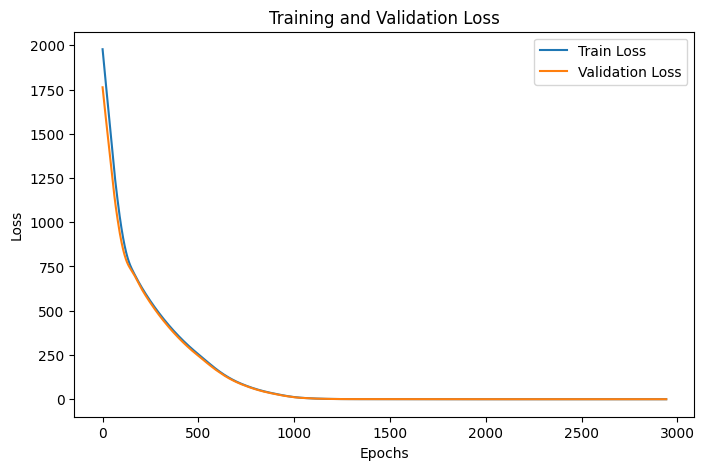

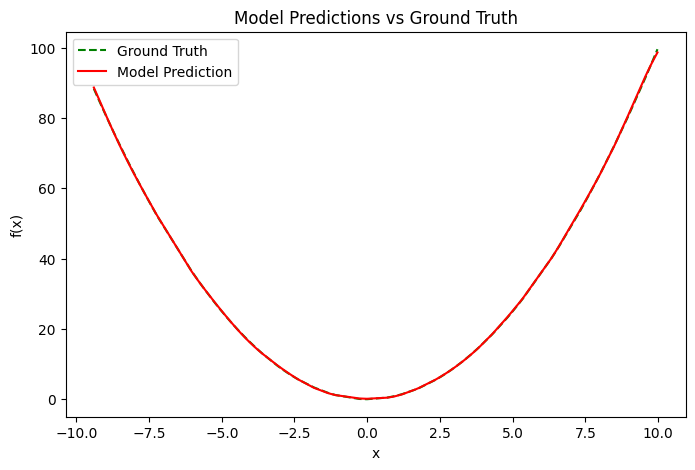

Mean Squared Error (MSE): 0.024473
Mean Absolute Error (MAE): 0.104108
R² Score: 0.999972

 Training model with Activation: Leaky ReLU, Optimizer: Adam
Epoch 0 → Train Loss: 1972.313599, Val Loss: 1720.051880
Epoch 100 → Train Loss: 85.663376, Val Loss: 84.327034
Epoch 200 → Train Loss: 5.650031, Val Loss: 5.038648
Epoch 300 → Train Loss: 0.762704, Val Loss: 0.504222
Epoch 400 → Train Loss: 0.252421, Val Loss: 0.132893
Epoch 500 → Train Loss: 0.091486, Val Loss: 0.081376
Epoch 600 → Train Loss: 0.064608, Val Loss: 0.058589
Epoch 700 → Train Loss: 0.044409, Val Loss: 0.039562
Epoch 800 → Train Loss: 0.056479, Val Loss: 0.040511
Epoch 900 → Train Loss: 0.052234, Val Loss: 0.029038
Early stopping at epoch 941


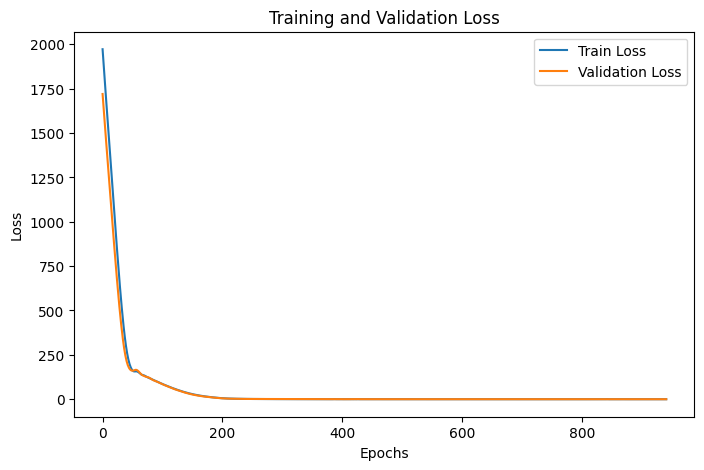

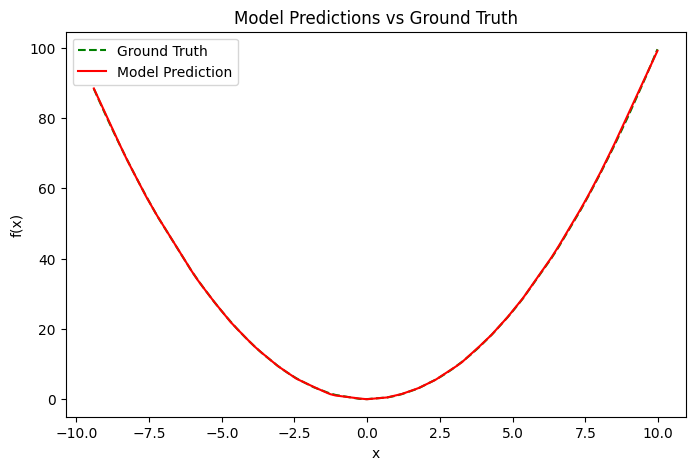

Mean Squared Error (MSE): 0.025817
Mean Absolute Error (MAE): 0.111299
R² Score: 0.999970

 Training model with Activation: ReLU, Optimizer: SGD
Epoch 0 → Train Loss: 2125.921143, Val Loss: 1915.199341
Epoch 100 → Train Loss: 1355.991211, Val Loss: 1223.477295
Epoch 200 → Train Loss: 674.932251, Val Loss: 617.487244
Epoch 300 → Train Loss: 224.277344, Val Loss: 215.521301
Epoch 400 → Train Loss: 124.637657, Val Loss: 127.473244
Epoch 500 → Train Loss: 105.458717, Val Loss: 106.862526
Epoch 600 → Train Loss: 88.251282, Val Loss: 88.643356
Epoch 700 → Train Loss: 72.525909, Val Loss: 72.294670
Epoch 800 → Train Loss: 57.621960, Val Loss: 57.059513
Epoch 900 → Train Loss: 45.203266, Val Loss: 44.444702
Epoch 1000 → Train Loss: 35.288723, Val Loss: 34.483578
Epoch 1100 → Train Loss: 27.284773, Val Loss: 26.157862
Epoch 1200 → Train Loss: 20.242474, Val Loss: 19.171988
Epoch 1300 → Train Loss: 14.245170, Val Loss: 13.570122
Epoch 1400 → Train Loss: 9.542192, Val Loss: 9.095277
Epoch 1500 → 

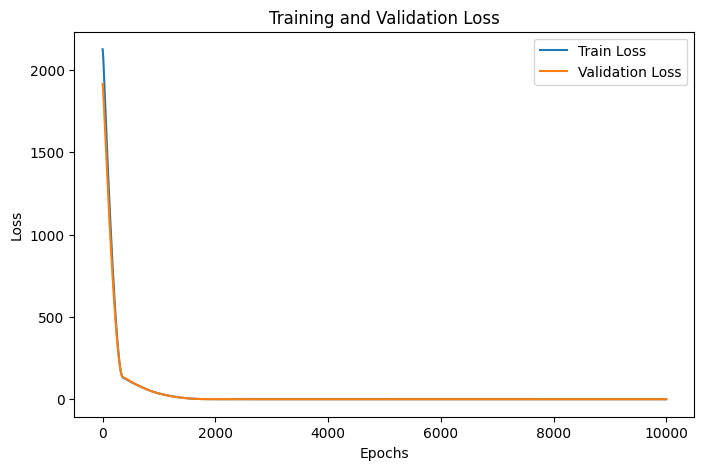

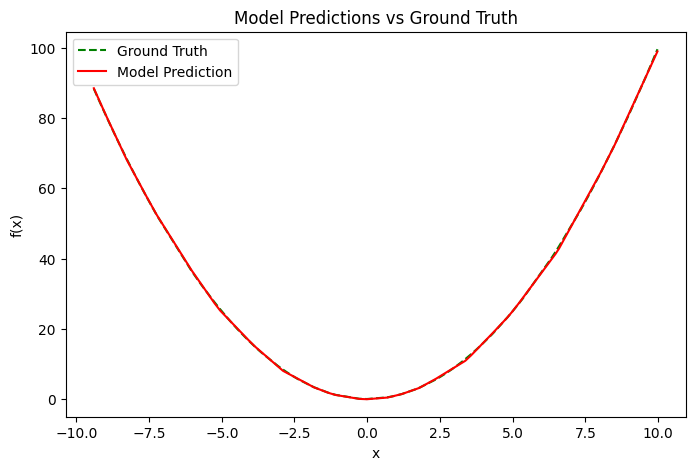

Mean Squared Error (MSE): 0.040550
Mean Absolute Error (MAE): 0.147832
R² Score: 0.999953

 Training model with Activation: Tanh, Optimizer: SGD
Epoch 0 → Train Loss: 2037.709473, Val Loss: 1826.762695
Epoch 100 → Train Loss: 1952.339844, Val Loss: 1751.803955
Epoch 200 → Train Loss: 1848.462524, Val Loss: 1659.237793
Epoch 300 → Train Loss: 1735.402222, Val Loss: 1558.405518
Epoch 400 → Train Loss: 1619.349121, Val Loss: 1455.018555
Epoch 500 → Train Loss: 1505.544556, Val Loss: 1354.058594
Epoch 600 → Train Loss: 1396.885986, Val Loss: 1258.276245
Epoch 700 → Train Loss: 1295.329956, Val Loss: 1170.484497
Epoch 800 → Train Loss: 1202.173096, Val Loss: 1091.391846
Epoch 900 → Train Loss: 1118.439819, Val Loss: 1021.839294
Epoch 1000 → Train Loss: 1044.865967, Val Loss: 962.425781
Epoch 1100 → Train Loss: 981.667236, Val Loss: 913.078369
Epoch 1200 → Train Loss: 927.912170, Val Loss: 872.258423
Epoch 1300 → Train Loss: 880.935181, Val Loss: 836.067322
Epoch 1400 → Train Loss: 835.95526

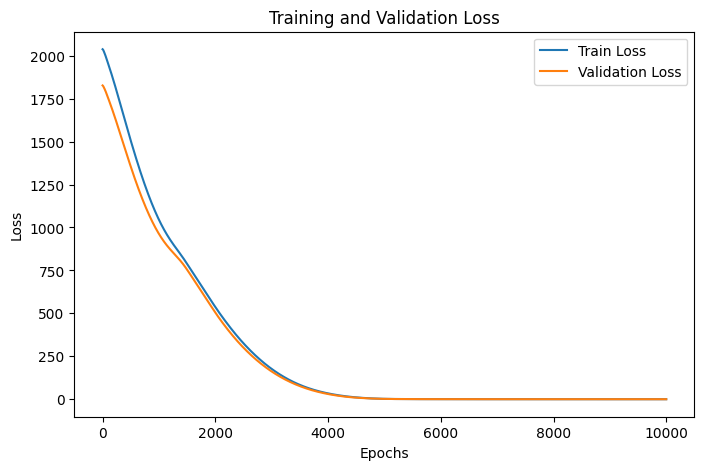

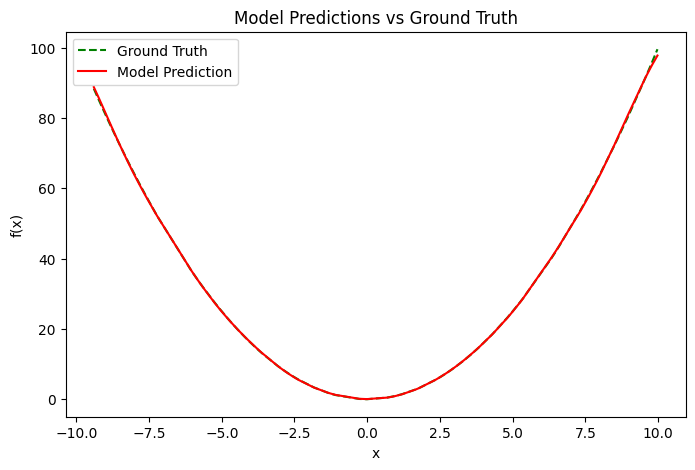

Mean Squared Error (MSE): 0.070103
Mean Absolute Error (MAE): 0.135867
R² Score: 0.999919

 Training model with Activation: Sigmoid, Optimizer: SGD
Epoch 0 → Train Loss: 2041.235352, Val Loss: 1829.748779
Epoch 100 → Train Loss: 1865.228760, Val Loss: 1669.653931
Epoch 200 → Train Loss: 1687.825806, Val Loss: 1511.541260
Epoch 300 → Train Loss: 1526.472778, Val Loss: 1369.822388
Epoch 400 → Train Loss: 1380.964966, Val Loss: 1244.445801
Epoch 500 → Train Loss: 1252.335693, Val Loss: 1135.181641
Epoch 600 → Train Loss: 1141.041626, Val Loss: 1042.017822
Epoch 700 → Train Loss: 1046.455811, Val Loss: 965.903442
Epoch 800 → Train Loss: 966.347168, Val Loss: 904.624451
Epoch 900 → Train Loss: 903.123657, Val Loss: 854.414673
Epoch 1000 → Train Loss: 855.875061, Val Loss: 822.404846
Epoch 1100 → Train Loss: 817.008606, Val Loss: 793.985168
Epoch 1200 → Train Loss: 780.835083, Val Loss: 763.437500
Epoch 1300 → Train Loss: 744.960754, Val Loss: 730.460449
Epoch 1400 → Train Loss: 709.437561, 

Mean Squared Error (MSE): 0.188125
Mean Absolute Error (MAE): 0.253747
R² Score: 0.999782

 Training model with Activation: Leaky ReLU, Optimizer: SGD
Epoch 0 → Train Loss: 2045.161255, Val Loss: 1846.995483
Epoch 100 → Train Loss: 1333.991699, Val Loss: 1231.074097
Epoch 200 → Train Loss: 700.089661, Val Loss: 671.804993
Epoch 300 → Train Loss: 260.161102, Val Loss: 260.063690
Epoch 400 → Train Loss: 131.568985, Val Loss: 131.218353
Epoch 500 → Train Loss: 111.211639, Val Loss: 110.450348
Epoch 600 → Train Loss: 92.704201, Val Loss: 91.778328
Epoch 700 → Train Loss: 75.183044, Val Loss: 74.179413
Epoch 800 → Train Loss: 59.782036, Val Loss: 59.017960
Epoch 900 → Train Loss: 47.306995, Val Loss: 47.057041
Epoch 1000 → Train Loss: 38.075447, Val Loss: 38.288864
Epoch 1100 → Train Loss: 30.485767, Val Loss: 30.668144
Epoch 1200 → Train Loss: 23.511030, Val Loss: 23.477266
Epoch 1300 → Train Loss: 17.297894, Val Loss: 17.178841
Epoch 1400 → Train Loss: 12.082994, Val Loss: 11.928352
Epoch

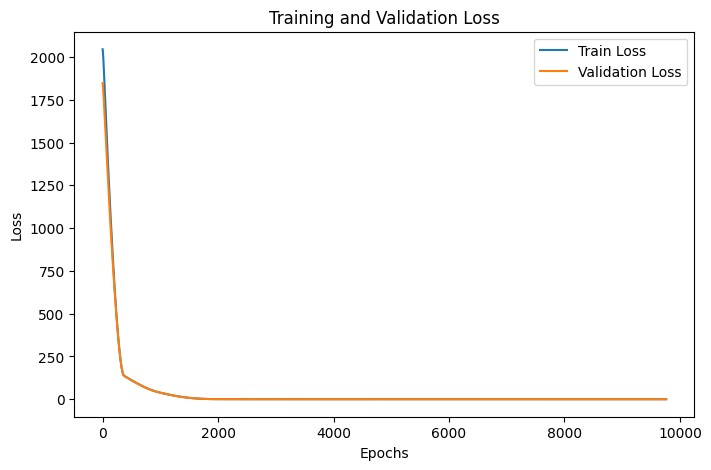

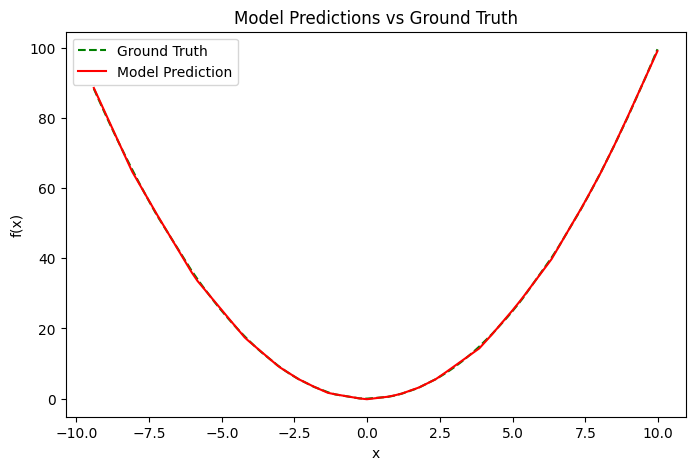

Mean Squared Error (MSE): 0.045581
Mean Absolute Error (MAE): 0.166968
R² Score: 0.999947

 Training model with Activation: ReLU, Optimizer: RMSprop
Epoch 0 → Train Loss: 1874.753540, Val Loss: 1260.861938
Epoch 100 → Train Loss: 30.135008, Val Loss: 27.663408
Epoch 200 → Train Loss: 12.336845, Val Loss: 11.267472
Epoch 300 → Train Loss: 5.221056, Val Loss: 4.677046
Epoch 400 → Train Loss: 2.753658, Val Loss: 2.244119
Epoch 500 → Train Loss: 1.975326, Val Loss: 1.223325
Epoch 600 → Train Loss: 1.688203, Val Loss: 0.765998
Epoch 700 → Train Loss: 1.411429, Val Loss: 0.630481
Early stopping at epoch 706


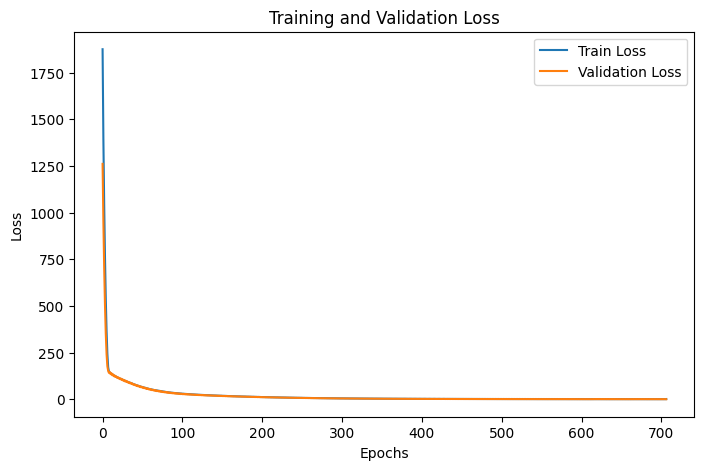

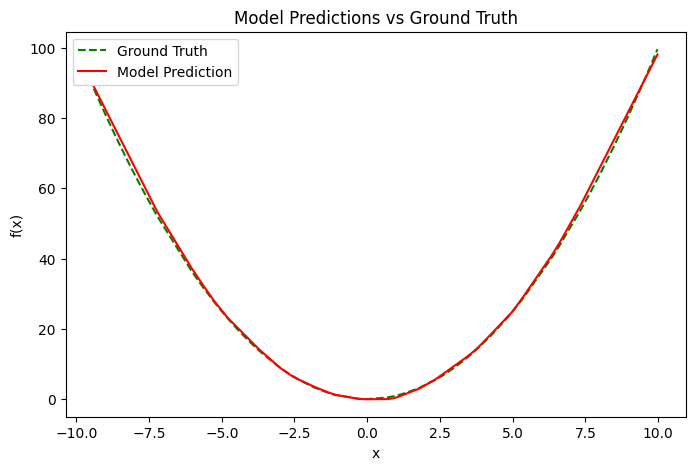

Mean Squared Error (MSE): 0.986303
Mean Absolute Error (MAE): 0.740418
R² Score: 0.998858

 Training model with Activation: Tanh, Optimizer: RMSprop
Epoch 0 → Train Loss: 2018.902710, Val Loss: 1804.539429
Epoch 100 → Train Loss: 377.363098, Val Loss: 347.811157
Epoch 200 → Train Loss: 164.071793, Val Loss: 152.830032
Epoch 300 → Train Loss: 91.141365, Val Loss: 82.730339
Epoch 400 → Train Loss: 52.870033, Val Loss: 46.504757
Epoch 500 → Train Loss: 31.485657, Val Loss: 26.689852
Epoch 600 → Train Loss: 18.866798, Val Loss: 15.690243
Epoch 700 → Train Loss: 11.158473, Val Loss: 9.640098
Epoch 800 → Train Loss: 5.729775, Val Loss: 5.947357
Epoch 900 → Train Loss: 2.906455, Val Loss: 3.966569
Epoch 1000 → Train Loss: 1.745322, Val Loss: 2.778728
Epoch 1100 → Train Loss: 1.130780, Val Loss: 3.040318
Epoch 1200 → Train Loss: 0.795422, Val Loss: 2.337998
Epoch 1300 → Train Loss: 0.630192, Val Loss: 2.044436
Epoch 1400 → Train Loss: 0.580066, Val Loss: 1.806185
Early stopping at epoch 1443


Mean Squared Error (MSE): 0.511743
Mean Absolute Error (MAE): 0.484752
R² Score: 0.999408

 Training model with Activation: Sigmoid, Optimizer: RMSprop
Epoch 0 → Train Loss: 2072.184570, Val Loss: 1754.726929
Epoch 100 → Train Loss: 663.496155, Val Loss: 664.439636
Epoch 200 → Train Loss: 513.013916, Val Loss: 516.730408
Epoch 300 → Train Loss: 401.002106, Val Loss: 406.386871
Epoch 400 → Train Loss: 308.587402, Val Loss: 313.578461
Epoch 500 → Train Loss: 198.964478, Val Loss: 198.584610
Epoch 600 → Train Loss: 120.887360, Val Loss: 119.044159
Epoch 700 → Train Loss: 67.009064, Val Loss: 64.789650
Epoch 800 → Train Loss: 37.699268, Val Loss: 35.490021
Epoch 900 → Train Loss: 21.039227, Val Loss: 19.754271
Epoch 1000 → Train Loss: 11.853552, Val Loss: 11.072527
Epoch 1100 → Train Loss: 7.011745, Val Loss: 6.461123
Epoch 1200 → Train Loss: 4.206198, Val Loss: 3.672890
Epoch 1300 → Train Loss: 2.468931, Val Loss: 1.838986
Epoch 1400 → Train Loss: 1.588825, Val Loss: 0.978315
Epoch 1500 →

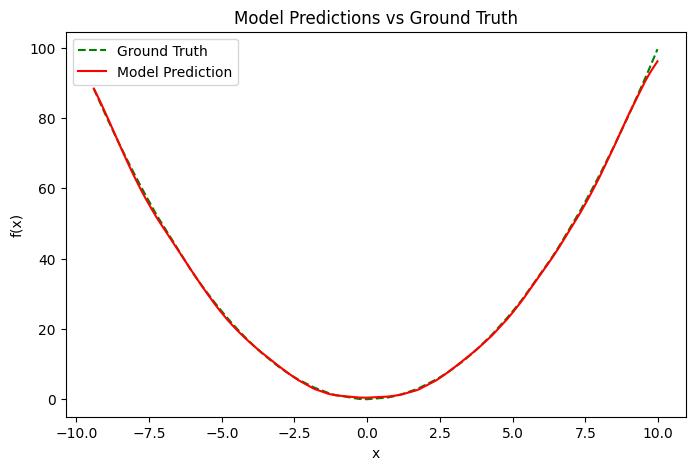

Mean Squared Error (MSE): 0.330000
Mean Absolute Error (MAE): 0.355756
R² Score: 0.999618

 Training model with Activation: Leaky ReLU, Optimizer: RMSprop
Epoch 0 → Train Loss: 1999.672485, Val Loss: 1303.674438
Epoch 100 → Train Loss: 33.630341, Val Loss: 32.744694
Epoch 200 → Train Loss: 10.372095, Val Loss: 9.567365
Epoch 300 → Train Loss: 4.511479, Val Loss: 4.322219
Epoch 400 → Train Loss: 2.529824, Val Loss: 2.360904
Epoch 500 → Train Loss: 1.746205, Val Loss: 1.549818
Epoch 600 → Train Loss: 1.346625, Val Loss: 1.219117
Epoch 700 → Train Loss: 1.107100, Val Loss: 1.098558
Epoch 800 → Train Loss: 0.971487, Val Loss: 1.043553
Epoch 900 → Train Loss: 0.891747, Val Loss: 1.011872
Epoch 1000 → Train Loss: 0.821756, Val Loss: 1.030634
Epoch 1100 → Train Loss: 0.748610, Val Loss: 1.043645
Epoch 1200 → Train Loss: 0.703770, Val Loss: 1.031555
Epoch 1300 → Train Loss: 0.665089, Val Loss: 1.104924
Epoch 1400 → Train Loss: 0.607163, Val Loss: 1.163419
Epoch 1500 → Train Loss: 0.560446, Val

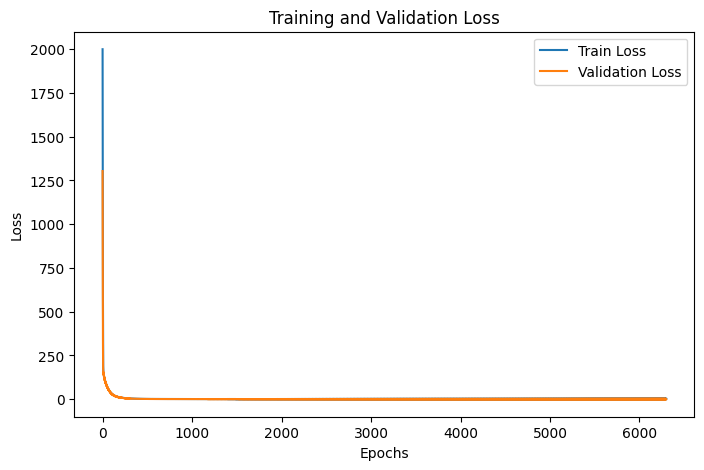

Mean Squared Error (MSE): 0.015541
Mean Absolute Error (MAE): 0.101530
R² Score: 0.999982


In [ ]:
fixed_architecture = {"hidden_size": 32, "num_layers": 1}

activation_functions = {
    "ReLU": F.relu,
    "Tanh": torch.tanh,
    "Sigmoid": torch.sigmoid,
    "Leaky ReLU": F.leaky_relu
}

optimizers = ["Adam", "SGD", "RMSprop"]

results = []

def start(opt = "Adam", epochs = 10000, learning_rate = 0.01):
  for act_name, act_func in activation_functions.items():
    print(f"\n Training model with Activation: {act_name}, Optimizer: {opt}")

    model = FeedforwardNN(hidden_size=fixed_architecture["hidden_size"], num_hidden_layers=fixed_architecture["num_layers"], activation_fn=act_func)

    loss_history, val_loss_history = train_model(model, X_train, y_train, X_val, y_val, epochs = epochs, learning_rate = learning_rate, patience=50, optimizer_type=opt)
    plot_predictions(model, X_test, y_test)

    mse, mae, r2 = evaluate_model(model, X_test, y_test)

    results.append({
        "Activation": act_name,
        "Optimizer": opt,
        "Final Train Loss": loss_history[-1],
        "Final Val Loss": val_loss_history[-1],
        "MSE": mse,
        "MAE": mae,
        "R² Score": r2
    })

start(opt = "Adam")
start(opt = "SGD", learning_rate = 0.001)
start(opt = "RMSprop")

df_results = pd.DataFrame(results)


In [ ]:
df_results

Activation Optimizer  Final Train Loss  Final Val Loss       MSE  \
0         ReLU      Adam          0.098186        0.196694  0.249799   
1         Tanh      Adam          0.022911        0.035367  0.040602   
2      Sigmoid      Adam          0.028708        0.019889  0.024473   
3   Leaky ReLU      Adam          0.037018        0.032535  0.025817   
4         ReLU       SGD          0.028961        0.032215  0.040550   
5         Tanh       SGD          0.065082        0.045942  0.070103   
6      Sigmoid       SGD          0.160745        0.146109  0.188125   
7   Leaky ReLU       SGD          0.039297        0.037711  0.045581   
8         ReLU   RMSprop          1.379803        0.645490  0.986303   
9         Tanh   RMSprop          1.767682        0.412581  0.511743   
10     Sigmoid   RMSprop          0.599799        0.240245  0.330000   
11  Leaky ReLU   RMSprop          2.473140        0.015939  0.015541   

         MAE  R² Score  
0   0.270847  0.999711  
1   0.120554  0.999953  
2   0.104108  0.999972  
3   0.111299  0.999970  
4   0.147832  0.999953  
5   0.135867  0.999919  
6   0.253747  0.999782  
7   0.166968  0.999947  
8   0.740418  0.998858  
9   0.484752  0.999408  
10  0.355756  0.999618  
11  0.101530  0.999982

Train set size: 800
Validation set size: 100
Test set size: 100


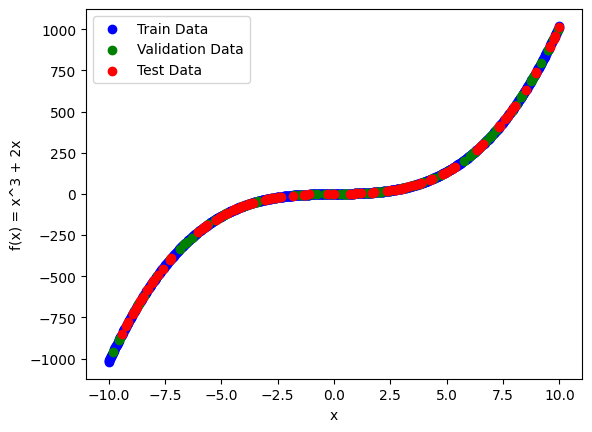

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Set random seed for reproducibility
torch.manual_seed(42)

# Generate dataset for f(x) = x^3 + 2x
x2 = np.linspace(-10, 10, 1000).reshape(-1, 1)
y2 = x2**3 + 2*x2  # Compute y = x^3 + 2x

# Convert to PyTorch tensors
x_tensor2 = torch.tensor(x2, dtype=torch.float32)
y_tensor2 = torch.tensor(y2, dtype=torch.float32)

# Split into Train (80%), Validation (10%), Test (10%)
X_train2, X_temp2, y_train2, y_temp2 = train_test_split(x_tensor2, y_tensor2, test_size=0.2, random_state=42)
X_val2, X_test2, y_val2, y_test2 = train_test_split(X_temp2, y_temp2, test_size=0.5, random_state=42)

# Print dataset sizes
print(f"Train set size: {len(X_train2)}")
print(f"Validation set size: {len(X_val2)}")
print(f"Test set size: {len(X_test2)}")

# Plot the data
plt.scatter(X_train2, y_train2, label="Train Data", color="blue")
plt.scatter(X_val2, y_val2, label="Validation Data", color="green")
plt.scatter(X_test2, y_test2, label="Test Data", color="red")
plt.xlabel("x")
plt.ylabel("f(x) = x^3 + 2x")
plt.legend()
plt.show()



🔹 Training model with 1 hidden layers and 4 neurons per layer 🔹
Epoch 0 → Train Loss: 152874.796875, Val Loss: 137394.187500
Epoch 100 → Train Loss: 141696.484375, Val Loss: 125018.890625
Epoch 200 → Train Loss: 120761.882812, Val Loss: 101589.226562
Epoch 300 → Train Loss: 98234.640625, Val Loss: 76098.328125
Epoch 400 → Train Loss: 89168.453125, Val Loss: 65156.738281
Epoch 500 → Train Loss: 87062.539062, Val Loss: 62869.226562
Epoch 600 → Train Loss: 85668.546875, Val Loss: 61393.316406
Epoch 700 → Train Loss: 84409.890625, Val Loss: 60082.429688
Epoch 800 → Train Loss: 83134.867188, Val Loss: 58753.820312
Epoch 900 → Train Loss: 81817.148438, Val Loss: 57387.609375
Epoch 1000 → Train Loss: 80495.257812, Val Loss: 56057.628906
Epoch 1100 → Train Loss: 79224.796875, Val Loss: 54809.316406
Epoch 1200 → Train Loss: 78043.093750, Val Loss: 53671.636719
Epoch 1300 → Train Loss: 76969.687500, Val Loss: 52682.601562
Epoch 1400 → Train Loss: 76016.078125, Val Loss: 51832.964844
Epoch 1500 

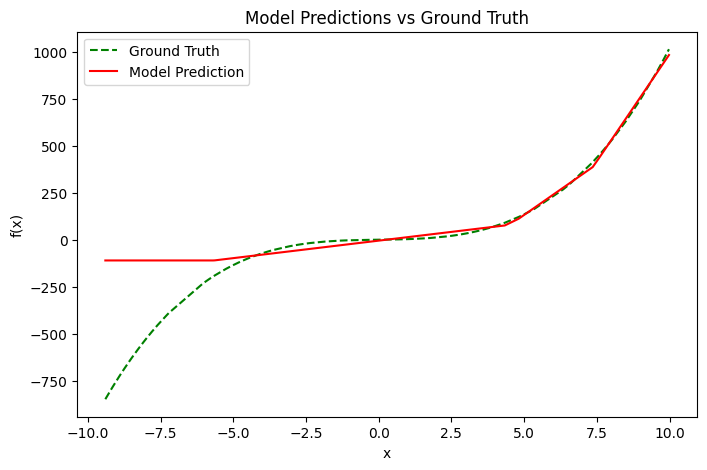

Mean Squared Error (MSE): 50478.855469
Mean Absolute Error (MAE): 109.079010
R² Score: 0.679954

🔹 Training model with 1 hidden layers and 8 neurons per layer 🔹
Epoch 0 → Train Loss: 152073.531250, Val Loss: 136660.078125
Epoch 100 → Train Loss: 126290.039062, Val Loss: 112810.679688
Epoch 200 → Train Loss: 74213.304688, Val Loss: 66917.890625
Epoch 300 → Train Loss: 31664.250000, Val Loss: 30242.134766
Epoch 400 → Train Loss: 23576.775391, Val Loss: 23148.019531
Epoch 500 → Train Loss: 20781.572266, Val Loss: 20303.394531
Epoch 600 → Train Loss: 18391.376953, Val Loss: 17862.587891
Epoch 700 → Train Loss: 15844.918945, Val Loss: 15259.886719
Epoch 800 → Train Loss: 13172.584961, Val Loss: 12553.272461
Epoch 900 → Train Loss: 10574.223633, Val Loss: 9929.194336
Epoch 1000 → Train Loss: 8205.849609, Val Loss: 7524.972656
Epoch 1100 → Train Loss: 6147.946777, Val Loss: 5500.659180
Epoch 1200 → Train Loss: 4425.078613, Val Loss: 3898.579346
Epoch 1300 → Train Loss: 3055.679932, Val Loss: 

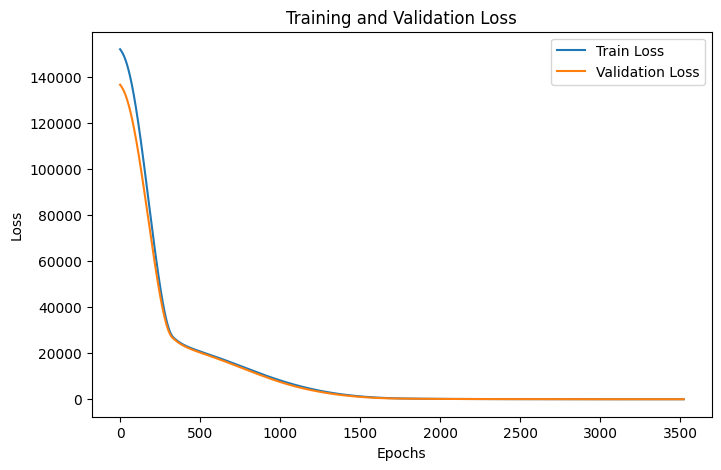

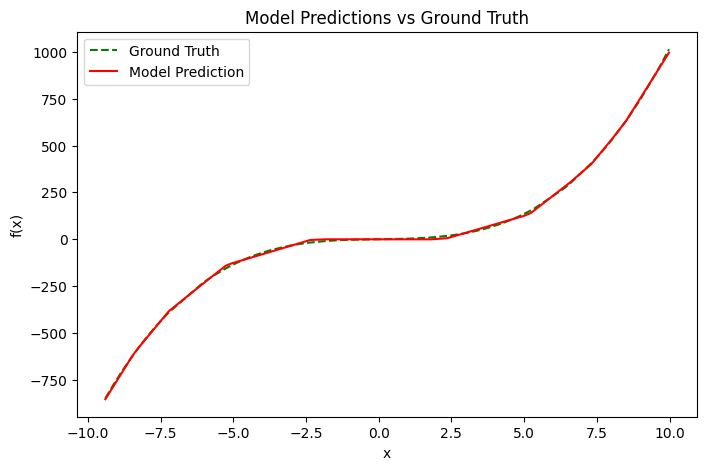

Mean Squared Error (MSE): 39.920719
Mean Absolute Error (MAE): 5.193444
R² Score: 0.999747

🔹 Training model with 1 hidden layers and 16 neurons per layer 🔹
Epoch 0 → Train Loss: 153832.875000, Val Loss: 138319.937500
Epoch 100 → Train Loss: 107646.382812, Val Loss: 95898.343750
Epoch 200 → Train Loss: 36279.531250, Val Loss: 32834.214844
Epoch 300 → Train Loss: 23180.427734, Val Loss: 22686.150391
Epoch 400 → Train Loss: 19740.744141, Val Loss: 19167.789062
Epoch 500 → Train Loss: 16347.784180, Val Loss: 15673.602539
Epoch 600 → Train Loss: 12705.782227, Val Loss: 12004.230469
Epoch 700 → Train Loss: 9279.076172, Val Loss: 8573.440430
Epoch 800 → Train Loss: 6370.160156, Val Loss: 5700.997070
Epoch 900 → Train Loss: 4092.822510, Val Loss: 3523.462158
Epoch 1000 → Train Loss: 2431.729736, Val Loss: 1995.746216
Epoch 1100 → Train Loss: 1315.768555, Val Loss: 1006.189453
Epoch 1200 → Train Loss: 654.819824, Val Loss: 473.112579
Epoch 1300 → Train Loss: 333.828308, Val Loss: 239.915939
Ep

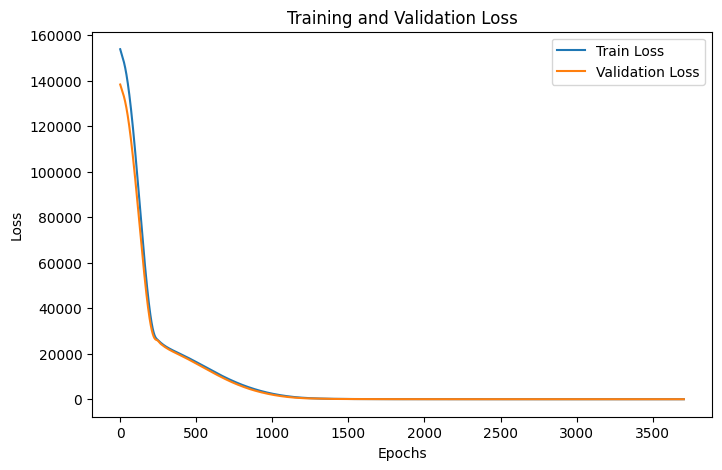

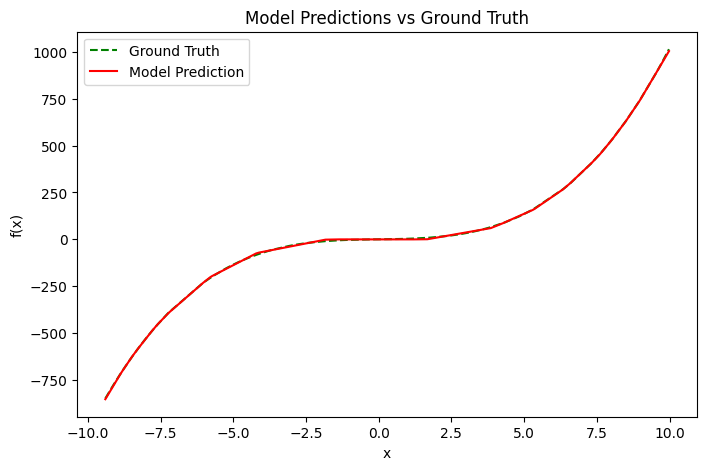

Mean Squared Error (MSE): 9.341239
Mean Absolute Error (MAE): 2.270178
R² Score: 0.999941

🔹 Training model with 1 hidden layers and 32 neurons per layer 🔹
Epoch 0 → Train Loss: 152745.093750, Val Loss: 137106.953125
Epoch 100 → Train Loss: 66823.351562, Val Loss: 64886.750000
Epoch 200 → Train Loss: 23843.304688, Val Loss: 23847.310547
Epoch 300 → Train Loss: 18480.550781, Val Loss: 18358.318359
Epoch 400 → Train Loss: 13729.342773, Val Loss: 13470.910156
Epoch 500 → Train Loss: 9544.558594, Val Loss: 9114.413086
Epoch 600 → Train Loss: 6134.995117, Val Loss: 5789.111328
Epoch 700 → Train Loss: 3588.256836, Val Loss: 3428.899902
Epoch 800 → Train Loss: 1875.412842, Val Loss: 1878.111450
Epoch 900 → Train Loss: 903.695251, Val Loss: 931.890137
Epoch 1000 → Train Loss: 428.458557, Val Loss: 432.253906
Epoch 1100 → Train Loss: 213.108444, Val Loss: 216.291290
Epoch 1200 → Train Loss: 117.724258, Val Loss: 125.465332
Epoch 1300 → Train Loss: 71.694519, Val Loss: 80.321976
Epoch 1400 → Tra

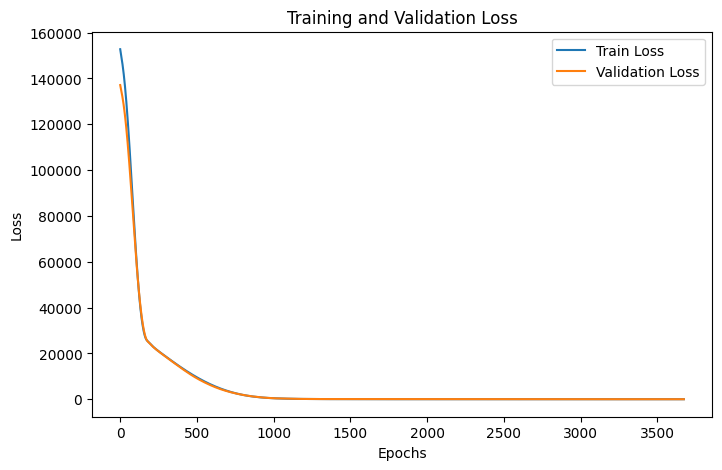

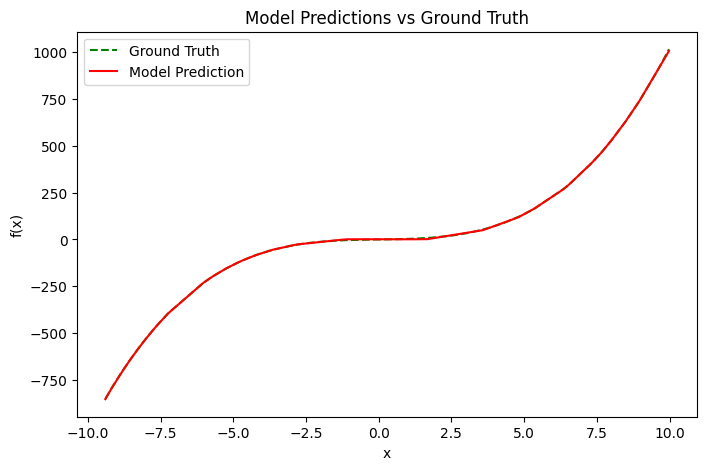

Mean Squared Error (MSE): 3.138117
Mean Absolute Error (MAE): 1.114500
R² Score: 0.999980

🔹 Training model with 1 hidden layers and 64 neurons per layer 🔹
Epoch 0 → Train Loss: 152957.500000, Val Loss: 137247.187500
Epoch 100 → Train Loss: 28950.132812, Val Loss: 28620.417969
Epoch 200 → Train Loss: 19002.208984, Val Loss: 18598.150391
Epoch 300 → Train Loss: 12275.469727, Val Loss: 11708.797852
Epoch 400 → Train Loss: 6437.801270, Val Loss: 5817.939453
Epoch 500 → Train Loss: 2589.319336, Val Loss: 2322.236084
Epoch 600 → Train Loss: 804.512817, Val Loss: 697.227478
Epoch 700 → Train Loss: 278.086792, Val Loss: 242.566528
Epoch 800 → Train Loss: 117.239197, Val Loss: 111.366798
Epoch 900 → Train Loss: 59.198887, Val Loss: 57.978806
Epoch 1000 → Train Loss: 33.763573, Val Loss: 32.890453
Epoch 1100 → Train Loss: 21.020502, Val Loss: 20.171074
Epoch 1200 → Train Loss: 13.903706, Val Loss: 12.481489
Epoch 1300 → Train Loss: 9.560430, Val Loss: 8.018229
Epoch 1400 → Train Loss: 8.407989,

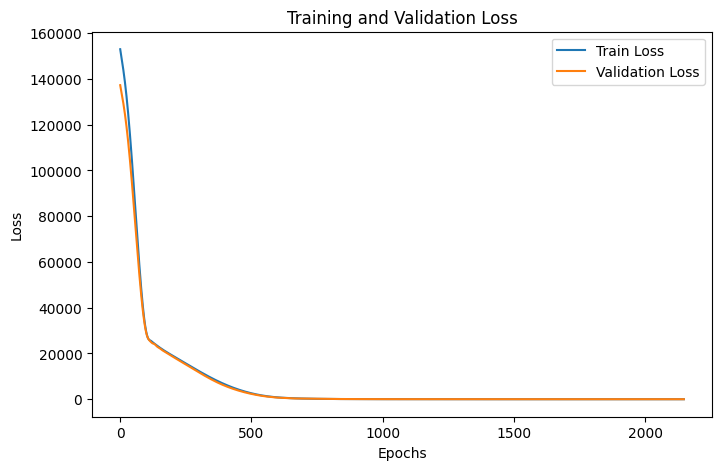

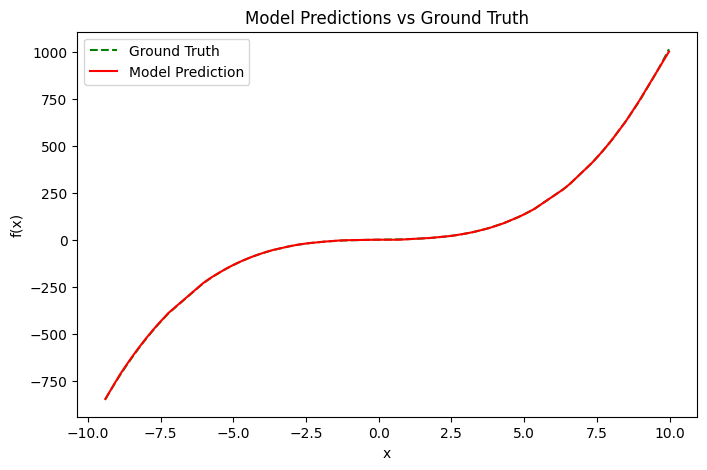

Mean Squared Error (MSE): 3.740951
Mean Absolute Error (MAE): 0.999601
R² Score: 0.999976

🔹 Training model with 2 hidden layers and 4 neurons per layer 🔹
Epoch 0 → Train Loss: 153106.375000, Val Loss: 137760.625000
Epoch 100 → Train Loss: 147535.312500, Val Loss: 133825.359375
Epoch 200 → Train Loss: 122141.710938, Val Loss: 116425.507812
Epoch 300 → Train Loss: 90777.687500, Val Loss: 97396.617188
Epoch 400 → Train Loss: 84453.968750, Val Loss: 93644.273438
Epoch 500 → Train Loss: 44089.515625, Val Loss: 48203.824219
Epoch 600 → Train Loss: 17838.949219, Val Loss: 18221.615234
Epoch 700 → Train Loss: 9292.324219, Val Loss: 8887.441406
Epoch 800 → Train Loss: 4855.156738, Val Loss: 4837.261719
Epoch 900 → Train Loss: 2232.634521, Val Loss: 2216.635742
Epoch 1000 → Train Loss: 2013.847656, Val Loss: 1901.719971
Early stopping at epoch 1094


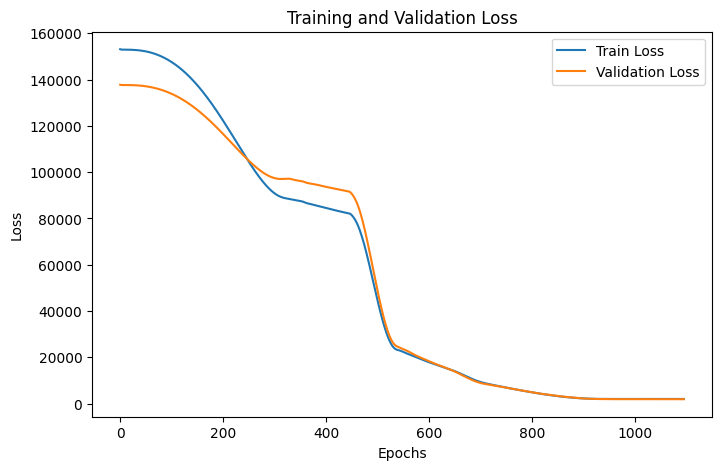

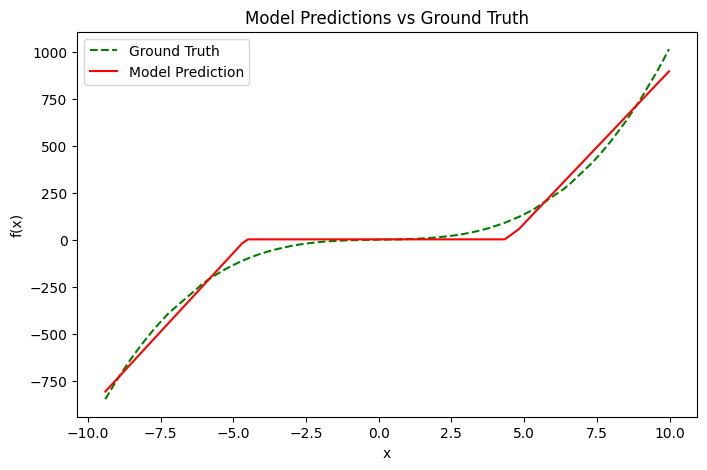

Mean Squared Error (MSE): 2408.695068
Mean Absolute Error (MAE): 39.925407
R² Score: 0.984728

🔹 Training model with 2 hidden layers and 8 neurons per layer 🔹
Epoch 0 → Train Loss: 152762.375000, Val Loss: 137342.328125
Epoch 100 → Train Loss: 78308.742188, Val Loss: 66149.125000
Epoch 200 → Train Loss: 22489.296875, Val Loss: 21919.664062
Epoch 300 → Train Loss: 14049.839844, Val Loss: 13364.174805
Epoch 400 → Train Loss: 4976.454590, Val Loss: 4361.279785
Epoch 500 → Train Loss: 808.461426, Val Loss: 588.266174
Epoch 600 → Train Loss: 217.626190, Val Loss: 171.458969
Epoch 700 → Train Loss: 143.196075, Val Loss: 141.216080
Epoch 800 → Train Loss: 105.612656, Val Loss: 96.991234
Epoch 900 → Train Loss: 80.465576, Val Loss: 84.106133
Epoch 1000 → Train Loss: 63.759567, Val Loss: 65.335663
Epoch 1100 → Train Loss: 52.962521, Val Loss: 51.478439
Epoch 1200 → Train Loss: 47.037521, Val Loss: 45.614555
Epoch 1300 → Train Loss: 43.567295, Val Loss: 40.909863
Epoch 1400 → Train Loss: 39.0668

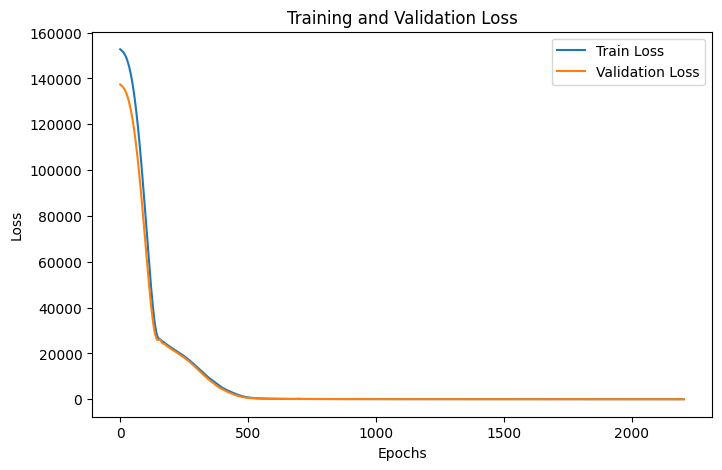

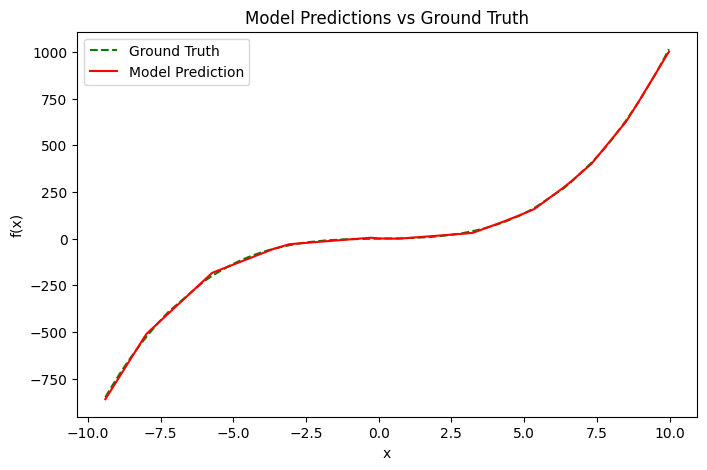

Mean Squared Error (MSE): 41.872814
Mean Absolute Error (MAE): 5.064853
R² Score: 0.999735

🔹 Training model with 2 hidden layers and 16 neurons per layer 🔹
Epoch 0 → Train Loss: 152839.812500, Val Loss: 137402.859375
Epoch 100 → Train Loss: 26890.193359, Val Loss: 26407.310547
Epoch 200 → Train Loss: 15998.826172, Val Loss: 15841.627930
Epoch 300 → Train Loss: 5153.626465, Val Loss: 4967.032715
Epoch 400 → Train Loss: 652.437866, Val Loss: 658.013489
Epoch 500 → Train Loss: 157.653458, Val Loss: 158.461563
Epoch 600 → Train Loss: 98.351875, Val Loss: 97.412727
Epoch 700 → Train Loss: 86.445320, Val Loss: 85.053665
Epoch 800 → Train Loss: 41.228371, Val Loss: 43.933060
Epoch 900 → Train Loss: 33.314720, Val Loss: 35.254993
Epoch 1000 → Train Loss: 28.897398, Val Loss: 27.110846
Epoch 1100 → Train Loss: 22.734829, Val Loss: 20.081837
Epoch 1200 → Train Loss: 17.740673, Val Loss: 16.023237
Epoch 1300 → Train Loss: 17.681307, Val Loss: 11.484985
Epoch 1400 → Train Loss: 12.038868, Val Los

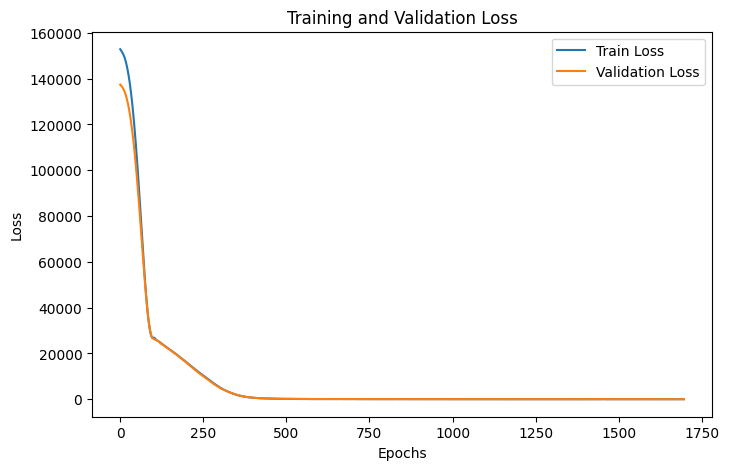

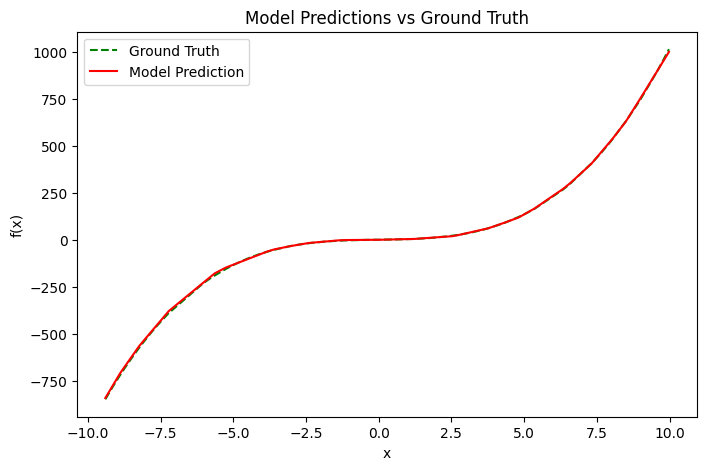

Mean Squared Error (MSE): 19.800362
Mean Absolute Error (MAE): 3.176111
R² Score: 0.999874

🔹 Training model with 2 hidden layers and 32 neurons per layer 🔹
Epoch 0 → Train Loss: 152747.343750, Val Loss: 136959.656250
Epoch 100 → Train Loss: 21569.419922, Val Loss: 20991.748047
Epoch 200 → Train Loss: 3976.495117, Val Loss: 3783.228516
Epoch 300 → Train Loss: 598.541809, Val Loss: 377.630768
Epoch 400 → Train Loss: 214.459610, Val Loss: 157.553925
Epoch 500 → Train Loss: 96.861511, Val Loss: 96.199997
Epoch 600 → Train Loss: 64.897362, Val Loss: 53.870483
Epoch 700 → Train Loss: 36.046253, Val Loss: 31.229607
Epoch 800 → Train Loss: 34.228497, Val Loss: 25.380562
Epoch 900 → Train Loss: 21.842749, Val Loss: 16.213356
Epoch 1000 → Train Loss: 19.493881, Val Loss: 13.430741
Early stopping at epoch 1082


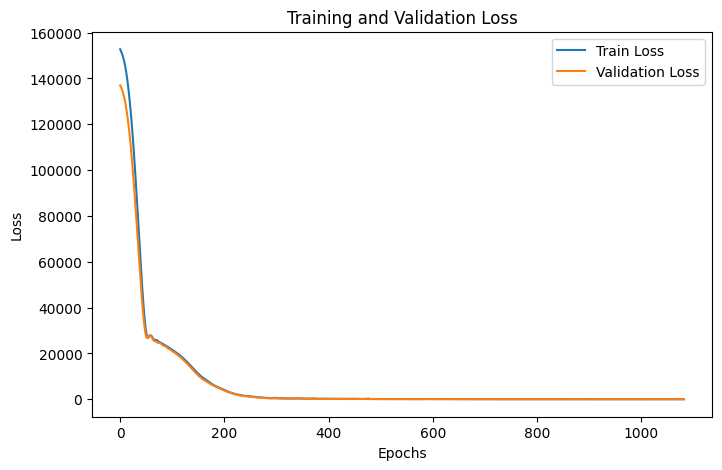

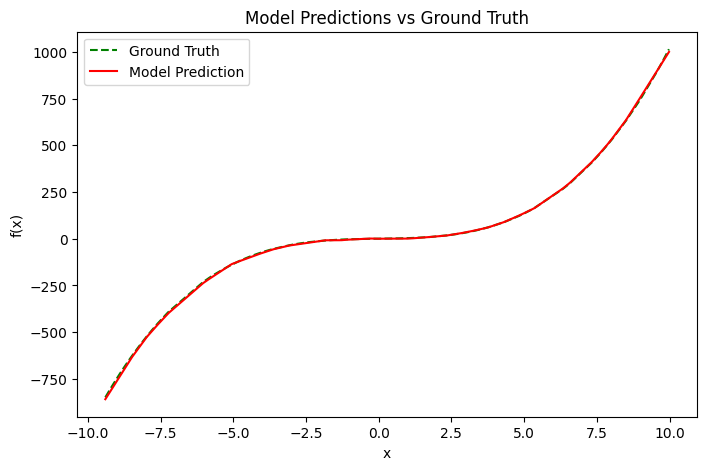

Mean Squared Error (MSE): 26.954145
Mean Absolute Error (MAE): 3.848513
R² Score: 0.999829

🔹 Training model with 2 hidden layers and 64 neurons per layer 🔹
Epoch 0 → Train Loss: 153020.062500, Val Loss: 136786.781250
Epoch 100 → Train Loss: 12301.177734, Val Loss: 11510.870117
Epoch 200 → Train Loss: 546.914001, Val Loss: 490.357117
Epoch 300 → Train Loss: 107.581680, Val Loss: 98.661446
Epoch 400 → Train Loss: 63.655285, Val Loss: 56.684917
Epoch 500 → Train Loss: 360.569214, Val Loss: 206.160507
Early stopping at epoch 543


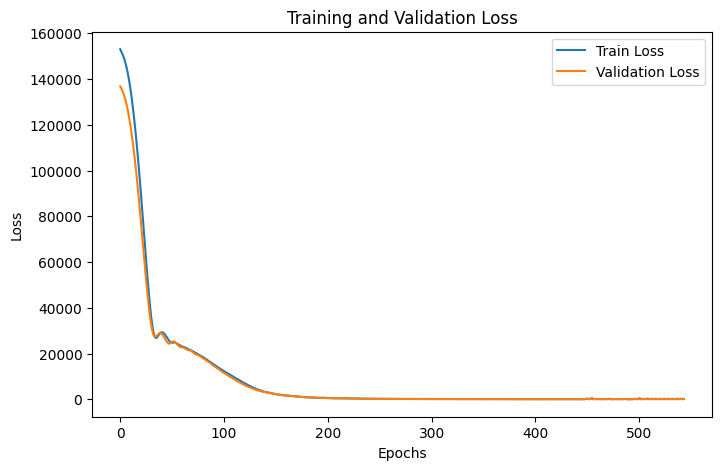

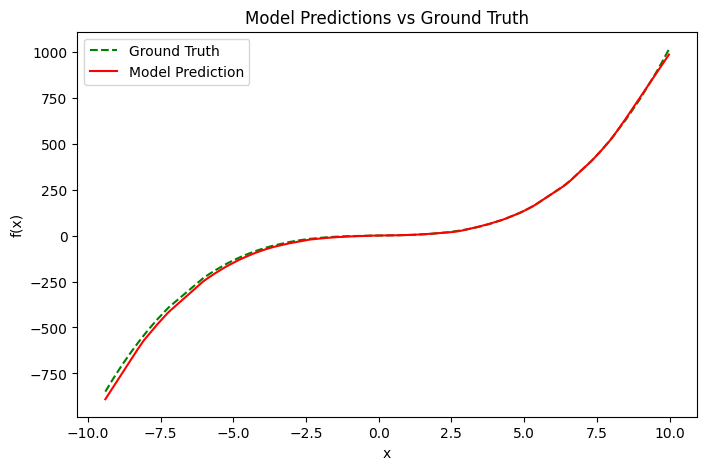

Mean Squared Error (MSE): 307.571808
Mean Absolute Error (MAE): 11.053561
R² Score: 0.998050

🔹 Training model with 3 hidden layers and 4 neurons per layer 🔹
Epoch 0 → Train Loss: 153069.984375, Val Loss: 137776.203125
Early stopping at epoch 60


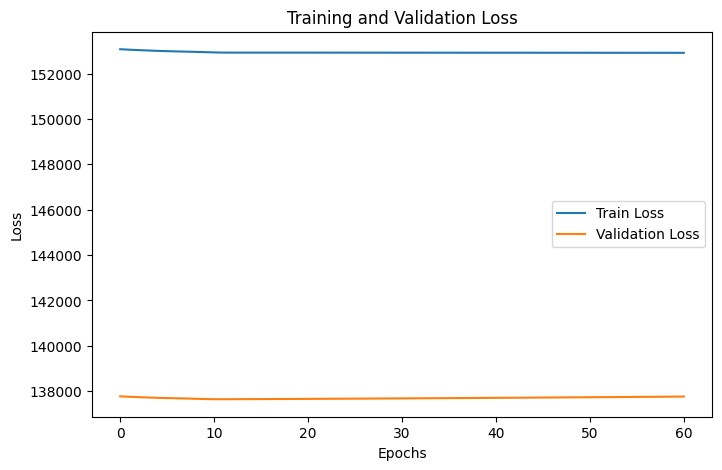

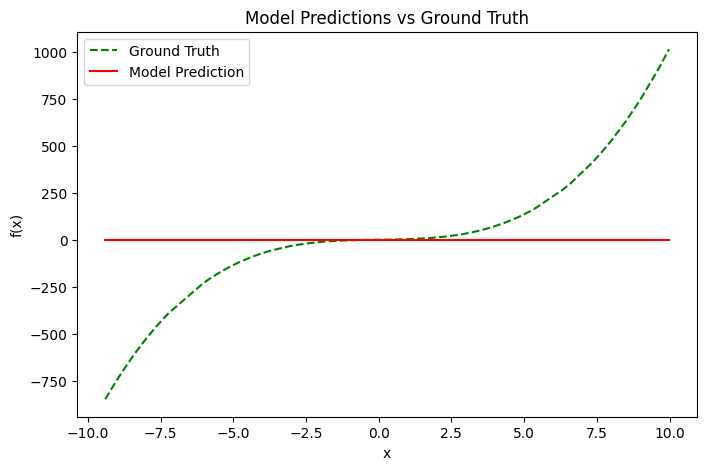

Mean Squared Error (MSE): 157779.546875
Mean Absolute Error (MAE): 272.359131
R² Score: -0.000354

🔹 Training model with 3 hidden layers and 8 neurons per layer 🔹
Epoch 0 → Train Loss: 153024.031250, Val Loss: 137675.484375
Epoch 100 → Train Loss: 27593.804688, Val Loss: 26392.992188
Epoch 200 → Train Loss: 10555.880859, Val Loss: 10607.655273
Epoch 300 → Train Loss: 4219.763672, Val Loss: 4534.569336
Epoch 400 → Train Loss: 1305.533081, Val Loss: 1317.914185
Epoch 500 → Train Loss: 830.362671, Val Loss: 837.636169
Epoch 600 → Train Loss: 569.400452, Val Loss: 571.515198
Epoch 700 → Train Loss: 436.495239, Val Loss: 429.494232
Epoch 800 → Train Loss: 396.090363, Val Loss: 376.474609
Epoch 900 → Train Loss: 376.027252, Val Loss: 346.747223
Epoch 1000 → Train Loss: 434.219452, Val Loss: 511.984650
Epoch 1100 → Train Loss: 342.817993, Val Loss: 345.124390
Early stopping at epoch 1180


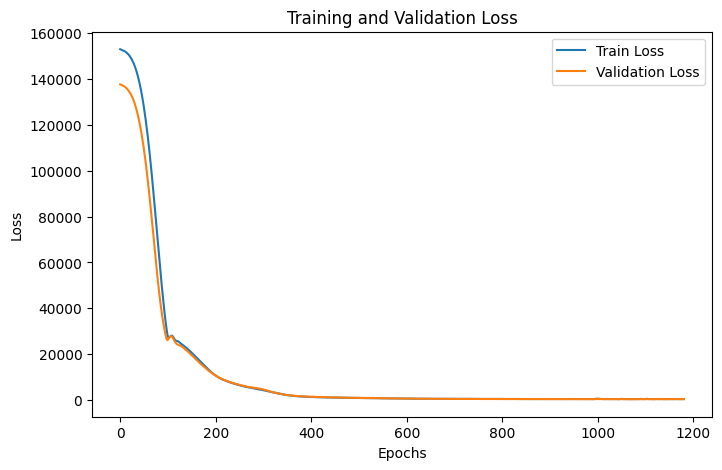

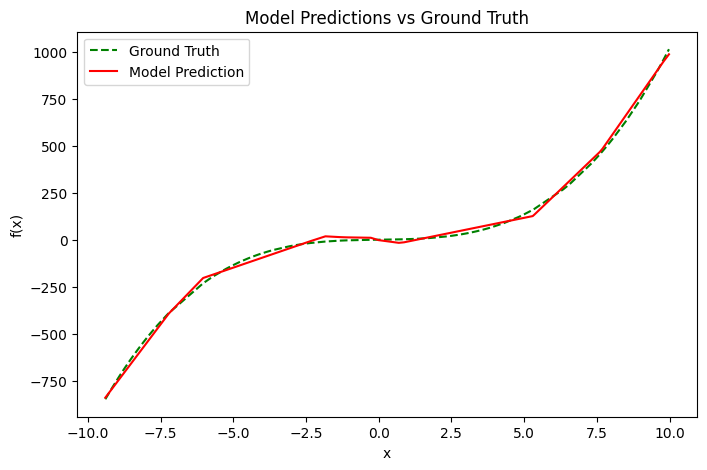

Mean Squared Error (MSE): 335.127228
Mean Absolute Error (MAE): 16.559914
R² Score: 0.997875

🔹 Training model with 3 hidden layers and 16 neurons per layer 🔹
Epoch 0 → Train Loss: 152822.812500, Val Loss: 137350.046875
Epoch 100 → Train Loss: 22515.990234, Val Loss: 21562.625000
Epoch 200 → Train Loss: 5116.860840, Val Loss: 4900.816406
Epoch 300 → Train Loss: 1059.118774, Val Loss: 993.946533
Epoch 400 → Train Loss: 204.499802, Val Loss: 210.006134
Epoch 500 → Train Loss: 108.221321, Val Loss: 102.732491
Epoch 600 → Train Loss: 68.093048, Val Loss: 63.120098
Epoch 700 → Train Loss: 63.465797, Val Loss: 54.085655
Epoch 800 → Train Loss: 48.467018, Val Loss: 39.985641
Epoch 900 → Train Loss: 37.735279, Val Loss: 29.190269
Epoch 1000 → Train Loss: 30.025877, Val Loss: 269.582123
Early stopping at epoch 1035


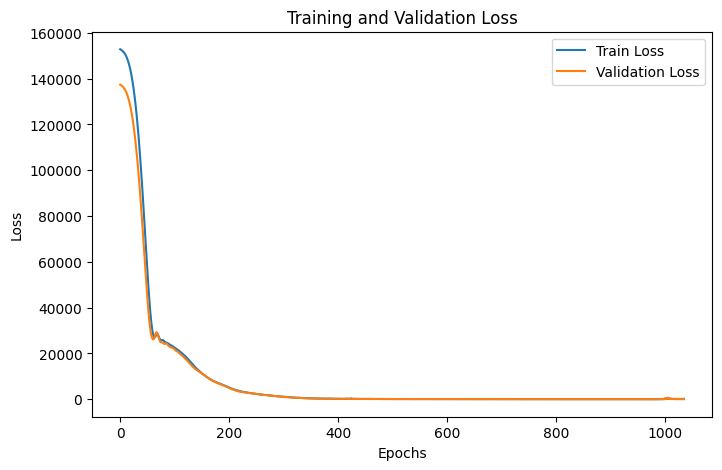

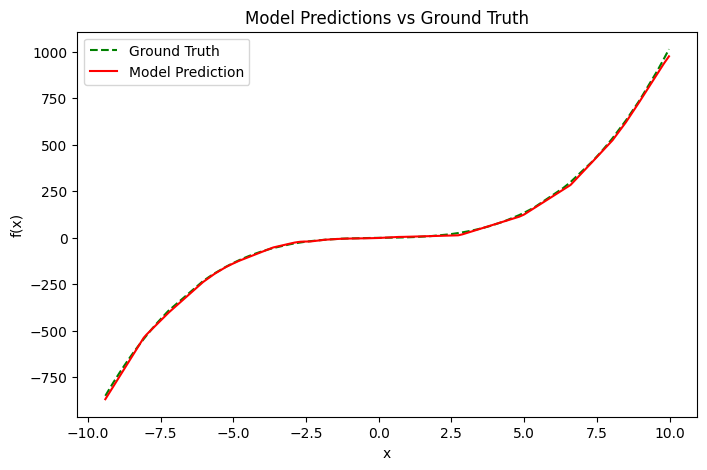

Mean Squared Error (MSE): 90.004021
Mean Absolute Error (MAE): 6.749435
R² Score: 0.999429

🔹 Training model with 3 hidden layers and 32 neurons per layer 🔹
Epoch 0 → Train Loss: 153062.546875, Val Loss: 137509.140625
Epoch 100 → Train Loss: 8469.989258, Val Loss: 7761.537598
Epoch 200 → Train Loss: 1094.487793, Val Loss: 904.540405
Epoch 300 → Train Loss: 237.556519, Val Loss: 144.201111
Epoch 400 → Train Loss: 140.905411, Val Loss: 102.730476
Early stopping at epoch 475


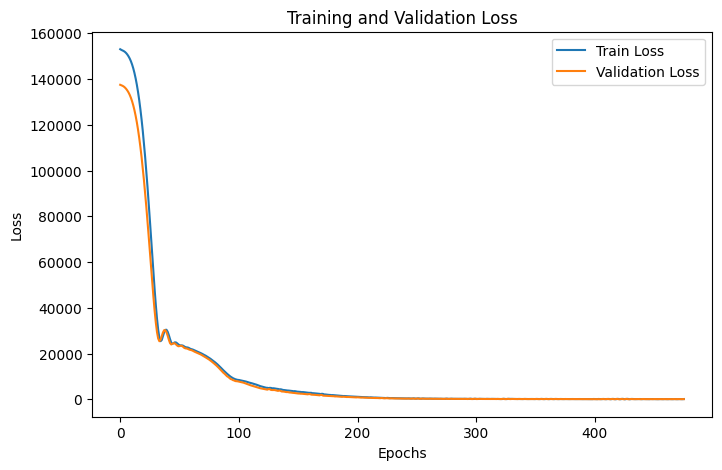

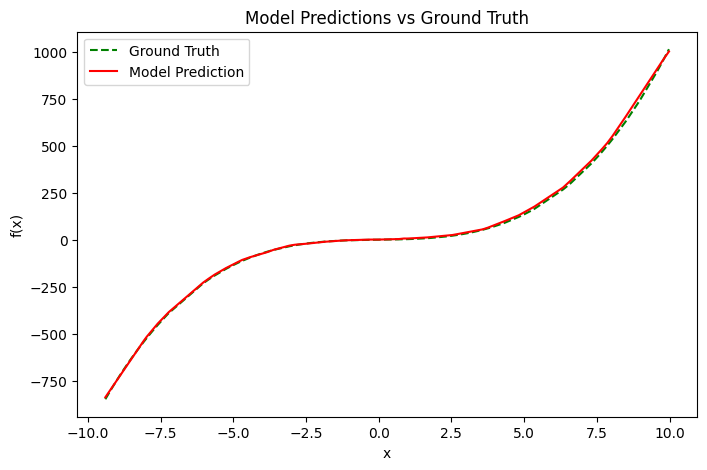

Mean Squared Error (MSE): 70.770515
Mean Absolute Error (MAE): 6.097915
R² Score: 0.999551

🔹 Training model with 3 hidden layers and 64 neurons per layer 🔹
Epoch 0 → Train Loss: 152880.546875, Val Loss: 137004.546875
Epoch 100 → Train Loss: 3936.057129, Val Loss: 3779.404297
Epoch 200 → Train Loss: 485.229187, Val Loss: 274.897491
Epoch 300 → Train Loss: 310.990265, Val Loss: 298.484558
Epoch 400 → Train Loss: 98.878654, Val Loss: 113.359123
Early stopping at epoch 417


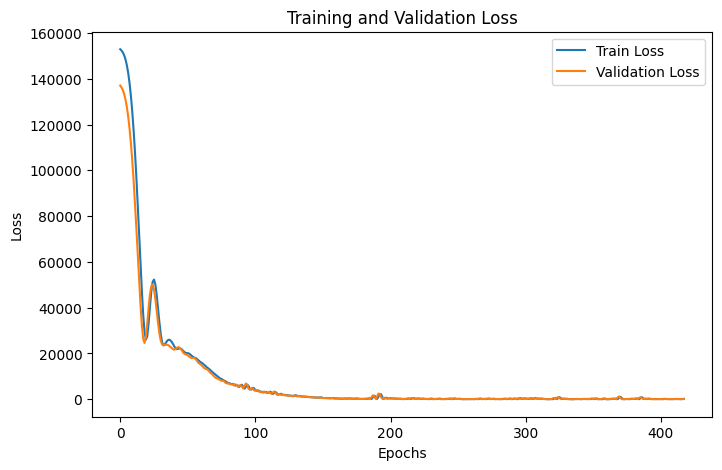

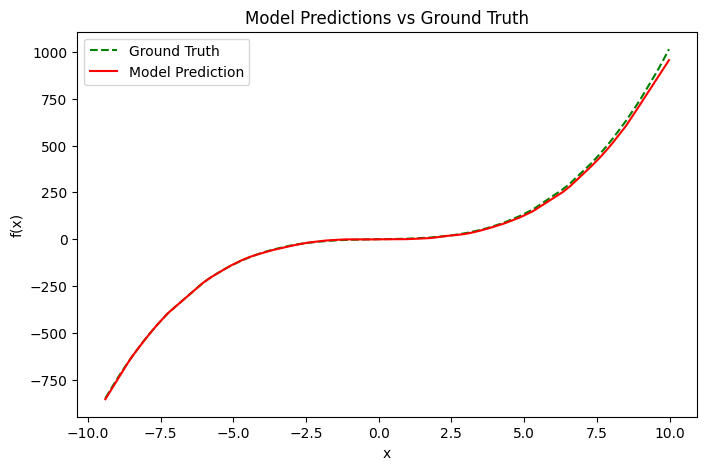

Mean Squared Error (MSE): 174.892365
Mean Absolute Error (MAE): 7.175941
R² Score: 0.998891


In [ ]:
# Define architectures to test
architectures2 = [
    {"hidden_size": 4, "num_layers": 1},
    {"hidden_size": 8, "num_layers": 1},
    {"hidden_size": 16, "num_layers": 1},
    {"hidden_size": 32, "num_layers": 1},
    {"hidden_size": 64, "num_layers": 1},
    {"hidden_size": 4, "num_layers": 2},
    {"hidden_size": 8, "num_layers": 2},
    {"hidden_size": 16, "num_layers": 2},
    {"hidden_size": 32, "num_layers": 2},
    {"hidden_size": 64, "num_layers": 2},
    {"hidden_size": 4, "num_layers": 3},
    {"hidden_size": 8, "num_layers": 3},
    {"hidden_size": 16, "num_layers": 3},
    {"hidden_size": 32, "num_layers": 3},
    {"hidden_size": 64, "num_layers": 3},
]

# Store results in a list
results2 = []

# Train and evaluate different architectures
for arch in architectures2:
    print(f"\n🔹 Training model with {arch['num_layers']} hidden layers and {arch['hidden_size']} neurons per layer 🔹")

    # Create model with given parameters
    model2 = FeedforwardNN(hidden_size=arch["hidden_size"], num_hidden_layers=arch["num_layers"])

    # Train model with Early Stopping and return loss history
    loss_history, val_loss_history = train_model(model2, X_train2, y_train2, X_val2, y_val2, epochs=10000, learning_rate=0.01, patience=50)

    # Plot predictions
    plot_predictions(model2, X_test2, y_test2)

    # Evaluate model performance
    mse, mae, r2 = evaluate_model(model2, X_test2, y_test2)

    # Store results
    results2.append({
        "Hidden Layers": arch["num_layers"],
        "Neurons per Layer": arch["hidden_size"],
        "Final Train Loss": loss_history[-1],
        "Final Validation Loss": val_loss_history[-1],
        "MSE": mse,
        "MAE": mae,
        "R² Score": r2
    })

# Convert results to Pandas DataFrame
df_results2 = pd.DataFrame(results2)


In [ ]:
# Display results table
df_results2

Hidden Layers  Neurons per Layer  Final Train Loss  Final Validation Loss  \
0               1                  4      53879.691406           35780.308594   
1               1                  8         41.722603              39.999779   
2               1                 16          8.877182               8.805212   
3               1                 32          3.082249               3.447325   
4               1                 64          3.420535               2.857483   
5               2                  4       2013.492310            1908.922974   
6               2                  8         31.196650              24.598623   
7               2                 16         14.198046              14.193365   
8               2                 32         21.352318              15.519851   
9               2                 64         96.075920             172.991409   
10              3                  4     152911.546875          137765.984375   
11              3                  8        351.028412             349.582886   
12              3                 16        177.248398              57.832577   
13              3                 32        130.321548             101.509544   
14              3                 64        140.450745             163.279556   

              MSE         MAE  R² Score  
0    50478.855469  109.079010  0.679954  
1       39.920719    5.193444  0.999747  
2        9.341239    2.270178  0.999941  
3        3.138117    1.114500  0.999980  
4        3.740951    0.999601  0.999976  
5     2408.695068   39.925407  0.984728  
6       41.872814    5.064853  0.999735  
7       19.800362    3.176111  0.999874  
8       26.954145    3.848513  0.999829  
9      307.571808   11.053561  0.998050  
10  157779.546875  272.359131 -0.000354  
11     335.127228   16.559914  0.997875  
12      90.004021    6.749435  0.999429  
13      70.770515    6.097915  0.999551  
14     174.892365    7.175941  0.998891


🔹 Training model with Activation: ReLU, Optimizer: Adam
Epoch 0 → Train Loss: 153780.046875, Val Loss: 137815.531250
Epoch 100 → Train Loss: 69239.062500, Val Loss: 63393.238281
Epoch 200 → Train Loss: 24027.662109, Val Loss: 23667.886719
Epoch 300 → Train Loss: 19256.064453, Val Loss: 18851.044922
Epoch 400 → Train Loss: 14765.557617, Val Loss: 14270.247070
Epoch 500 → Train Loss: 10192.412109, Val Loss: 9571.875977
Epoch 600 → Train Loss: 6260.307617, Val Loss: 5649.962402
Epoch 700 → Train Loss: 3350.425293, Val Loss: 2997.095703
Epoch 800 → Train Loss: 1513.032227, Val Loss: 1355.838135
Epoch 900 → Train Loss: 614.892334, Val Loss: 528.320923
Epoch 1000 → Train Loss: 266.779175, Val Loss: 234.560196
Epoch 1100 → Train Loss: 129.612244, Val Loss: 122.168221
Epoch 1200 → Train Loss: 71.186432, Val Loss: 70.196922
Epoch 1300 → Train Loss: 43.181469, Val Loss: 43.255299
Epoch 1400 → Train Loss: 28.333445, Val Loss: 27.708296
Epoch 1500 → Train Loss: 19.843033, Val Loss: 19.191797
Epoc

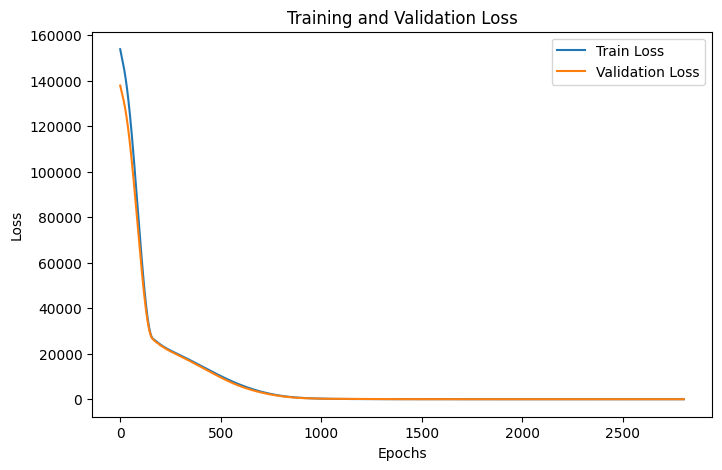

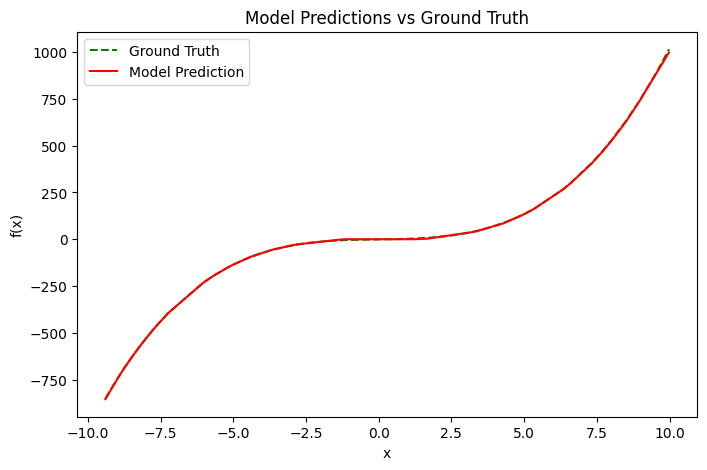

Mean Squared Error (MSE): 7.390763
Mean Absolute Error (MAE): 1.512170
R² Score: 0.999953

🔹 Training model with Activation: Tanh, Optimizer: Adam
Epoch 0 → Train Loss: 152782.343750, Val Loss: 137379.718750
Epoch 100 → Train Loss: 136910.703125, Val Loss: 123249.539062
Epoch 200 → Train Loss: 122308.101562, Val Loss: 110324.632812
Epoch 300 → Train Loss: 109054.000000, Val Loss: 98609.882812
Epoch 400 → Train Loss: 96974.648438, Val Loss: 87915.507812
Epoch 500 → Train Loss: 85972.812500, Val Loss: 78163.382812
Epoch 600 → Train Loss: 75960.320312, Val Loss: 69257.617188
Epoch 700 → Train Loss: 66852.953125, Val Loss: 61141.195312
Epoch 800 → Train Loss: 58585.914062, Val Loss: 53760.046875
Epoch 900 → Train Loss: 51103.613281, Val Loss: 47055.503906
Epoch 1000 → Train Loss: 44346.093750, Val Loss: 40966.230469
Epoch 1100 → Train Loss: 38266.531250, Val Loss: 35433.691406
Epoch 1200 → Train Loss: 32814.015625, Val Loss: 30415.187500
Epoch 1300 → Train Loss: 27941.162109, Val Loss: 258

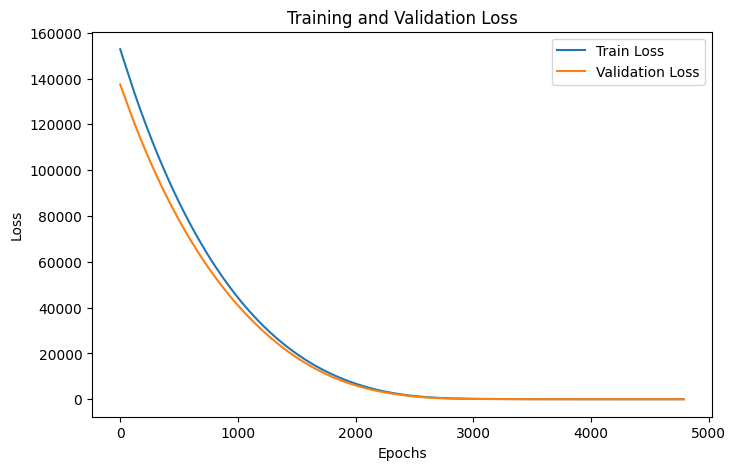

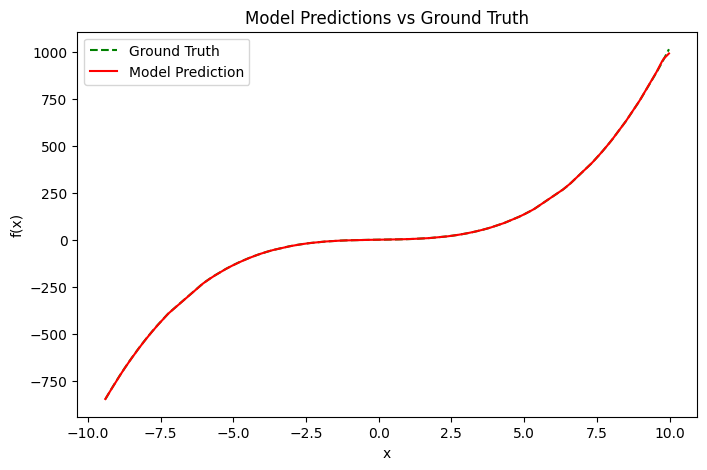

Mean Squared Error (MSE): 5.752917
Mean Absolute Error (MAE): 0.639231
R² Score: 0.999964

🔹 Training model with Activation: Sigmoid, Optimizer: Adam
Epoch 0 → Train Loss: 152882.375000, Val Loss: 137475.562500
Epoch 100 → Train Loss: 144659.515625, Val Loss: 130181.171875
Epoch 200 → Train Loss: 136821.296875, Val Loss: 123266.437500
Epoch 300 → Train Loss: 129407.578125, Val Loss: 116729.609375
Epoch 400 → Train Loss: 122316.656250, Val Loss: 110487.359375
Epoch 500 → Train Loss: 115535.187500, Val Loss: 104527.640625
Epoch 600 → Train Loss: 109058.773438, Val Loss: 98827.570312
Epoch 700 → Train Loss: 102881.820312, Val Loss: 93376.320312
Epoch 800 → Train Loss: 96988.593750, Val Loss: 88162.289062
Epoch 900 → Train Loss: 91363.640625, Val Loss: 83175.921875
Epoch 1000 → Train Loss: 85993.906250, Val Loss: 78405.695312
Epoch 1100 → Train Loss: 80869.265625, Val Loss: 73841.710938
Epoch 1200 → Train Loss: 75980.593750, Val Loss: 69476.718750
Epoch 1300 → Train Loss: 71319.039062, Val

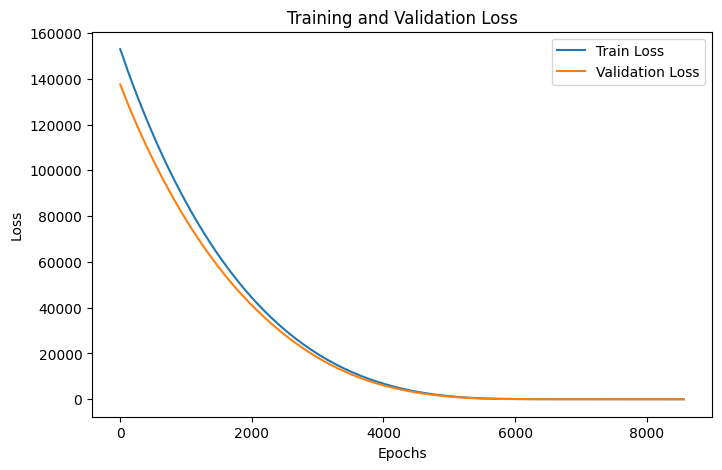

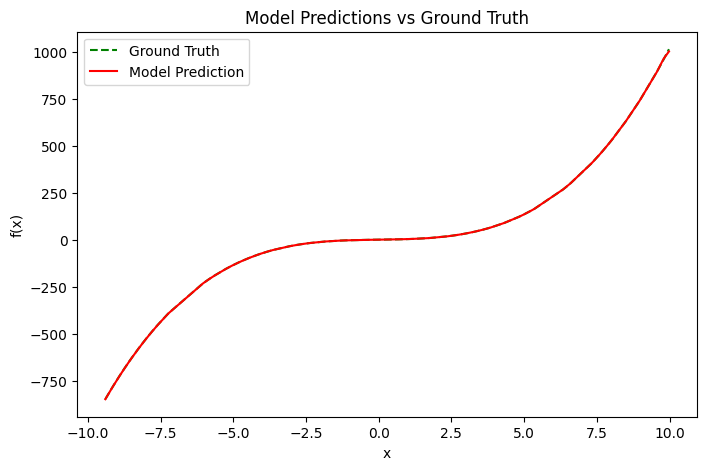

Mean Squared Error (MSE): 1.655307
Mean Absolute Error (MAE): 0.355364
R² Score: 0.999990

🔹 Training model with Activation: Leaky ReLU, Optimizer: Adam
Epoch 0 → Train Loss: 152812.093750, Val Loss: 137063.765625
Epoch 100 → Train Loss: 64850.773438, Val Loss: 56349.285156
Epoch 200 → Train Loss: 23657.214844, Val Loss: 23203.652344
Epoch 300 → Train Loss: 19017.312500, Val Loss: 18478.289062
Epoch 400 → Train Loss: 14439.206055, Val Loss: 13803.170898
Epoch 500 → Train Loss: 9756.488281, Val Loss: 9060.612305
Epoch 600 → Train Loss: 5804.282715, Val Loss: 5151.600098
Epoch 700 → Train Loss: 2985.623047, Val Loss: 2544.518555
Epoch 800 → Train Loss: 1279.953491, Val Loss: 1008.163574
Epoch 900 → Train Loss: 503.500366, Val Loss: 371.955170
Epoch 1000 → Train Loss: 206.233261, Val Loss: 163.359665
Epoch 1100 → Train Loss: 97.006638, Val Loss: 83.564552
Epoch 1200 → Train Loss: 52.281387, Val Loss: 46.486187
Epoch 1300 → Train Loss: 31.197512, Val Loss: 27.945467
Epoch 1400 → Train Loss

Mean Squared Error (MSE): 4.004737
Mean Absolute Error (MAE): 1.254813
R² Score: 0.999975

🔹 Training model with Activation: ReLU, Optimizer: SGD
Epoch 0 → Train Loss: 153239.953125, Val Loss: 138046.343750
Epoch 100 → Train Loss: 56824.003906, Val Loss: 52717.390625
Epoch 200 → Train Loss: 21324.757812, Val Loss: 20933.140625
Epoch 300 → Train Loss: 15574.415039, Val Loss: 15042.567383
Epoch 400 → Train Loss: 9588.012695, Val Loss: 8917.859375
Epoch 500 → Train Loss: 4811.296387, Val Loss: 4263.899902
Epoch 600 → Train Loss: 1875.875977, Val Loss: 1616.260254
Epoch 700 → Train Loss: 514.608459, Val Loss: 407.248779
Epoch 800 → Train Loss: 140.910248, Val Loss: 123.701004
Epoch 900 → Train Loss: 71.297417, Val Loss: 66.198372
Epoch 1000 → Train Loss: 45.249947, Val Loss: 42.596352
Epoch 1100 → Train Loss: 32.105446, Val Loss: 30.270840
Epoch 1200 → Train Loss: 24.417427, Val Loss: 22.888046
Epoch 1300 → Train Loss: 19.594233, Val Loss: 17.926983
Epoch 1400 → Train Loss: 16.318695, Val 

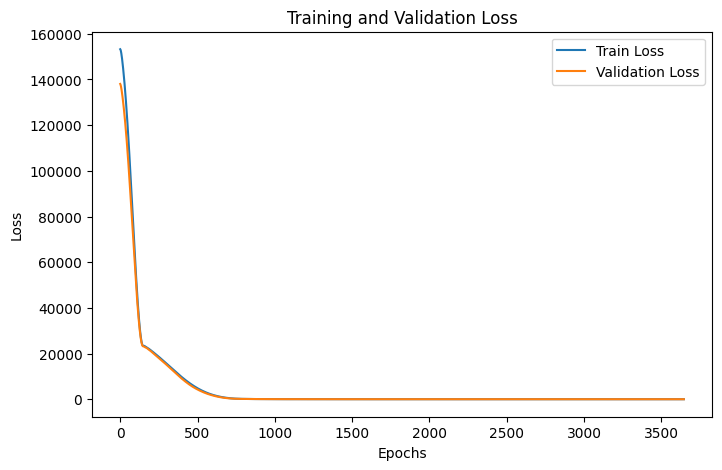

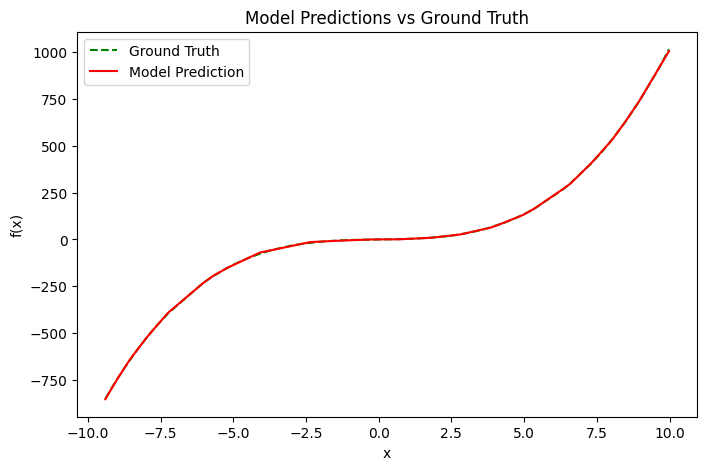

Mean Squared Error (MSE): 3.990638
Mean Absolute Error (MAE): 1.344518
R² Score: 0.999975

🔹 Training model with Activation: Tanh, Optimizer: SGD
Epoch 0 → Train Loss: 152823.765625, Val Loss: 137555.234375
Epoch 100 → Train Loss: 128517.007812, Val Loss: 115569.429688
Epoch 200 → Train Loss: 106076.898438, Val Loss: 95727.000000
Epoch 300 → Train Loss: 87529.578125, Val Loss: 79332.687500
Epoch 400 → Train Loss: 71791.820312, Val Loss: 65404.484375
Epoch 500 → Train Loss: 58000.699219, Val Loss: 52975.261719
Epoch 600 → Train Loss: 45981.921875, Val Loss: 42007.171875
Epoch 700 → Train Loss: 35785.394531, Val Loss: 32719.095703
Epoch 800 → Train Loss: 27346.859375, Val Loss: 25025.597656
Epoch 900 → Train Loss: 20469.599609, Val Loss: 18667.121094
Epoch 1000 → Train Loss: 14946.946289, Val Loss: 13472.532227
Epoch 1100 → Train Loss: 10601.242188, Val Loss: 9370.276367
Epoch 1200 → Train Loss: 7226.583984, Val Loss: 6254.585449
Epoch 1300 → Train Loss: 4691.989746, Val Loss: 3994.67187

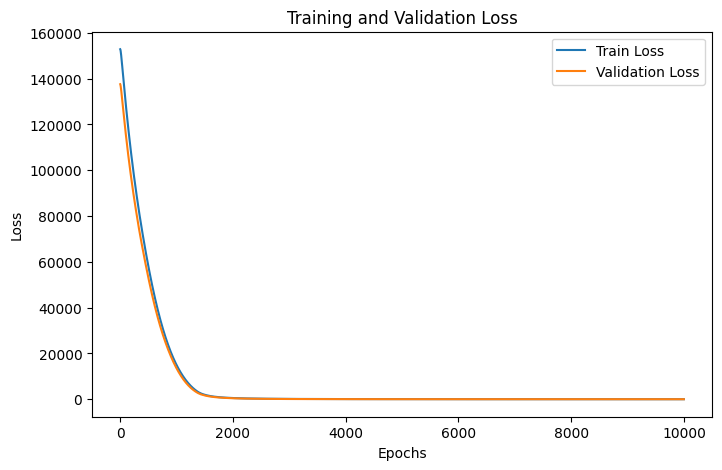

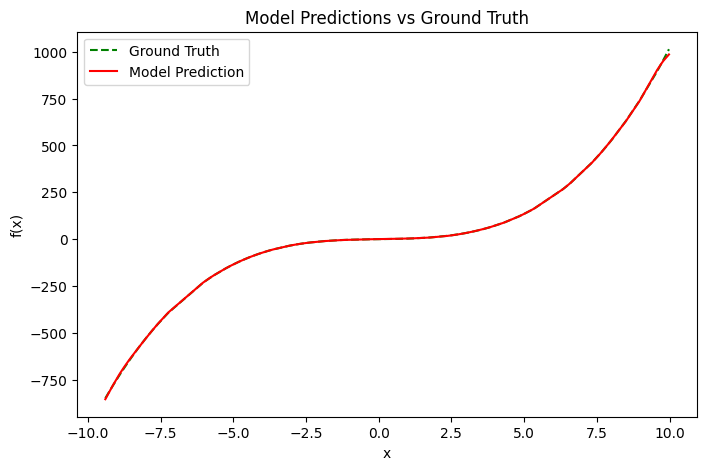

Mean Squared Error (MSE): 10.848844
Mean Absolute Error (MAE): 1.111343
R² Score: 0.999931

🔹 Training model with Activation: Sigmoid, Optimizer: SGD
Epoch 0 → Train Loss: 152825.703125, Val Loss: 137576.062500
Epoch 100 → Train Loss: 140249.781250, Val Loss: 126246.242188
Epoch 200 → Train Loss: 127222.976562, Val Loss: 114652.656250
Epoch 300 → Train Loss: 115454.156250, Val Loss: 104250.546875
Epoch 400 → Train Loss: 104830.289062, Val Loss: 94904.039062
Epoch 500 → Train Loss: 95229.156250, Val Loss: 86488.257812
Epoch 600 → Train Loss: 86574.031250, Val Loss: 78945.898438
Epoch 700 → Train Loss: 78729.539062, Val Loss: 72111.312500
Epoch 800 → Train Loss: 71458.851562, Val Loss: 65707.632812
Epoch 900 → Train Loss: 64501.789062, Val Loss: 59456.218750
Epoch 1000 → Train Loss: 57819.371094, Val Loss: 53346.359375
Epoch 1100 → Train Loss: 51526.453125, Val Loss: 47542.800781
Epoch 1200 → Train Loss: 45705.039062, Val Loss: 42169.171875
Epoch 1300 → Train Loss: 40369.781250, Val Loss

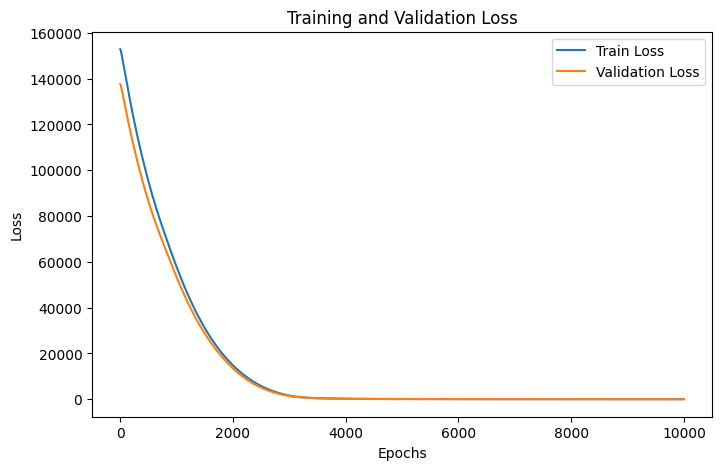

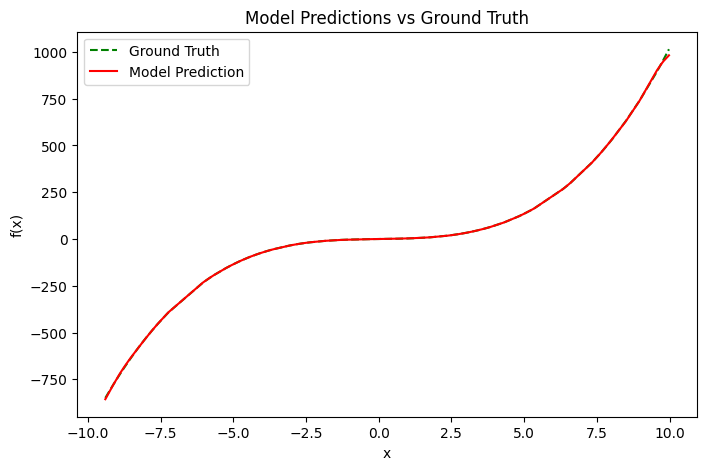

Mean Squared Error (MSE): 13.616142
Mean Absolute Error (MAE): 1.060134
R² Score: 0.999914

🔹 Training model with Activation: Leaky ReLU, Optimizer: SGD
Epoch 0 → Train Loss: 153451.734375, Val Loss: 138105.765625
Epoch 100 → Train Loss: 59070.730469, Val Loss: 56554.781250
Epoch 200 → Train Loss: 21634.607422, Val Loss: 21164.625000
Epoch 300 → Train Loss: 15984.302734, Val Loss: 15389.749023
Epoch 400 → Train Loss: 9988.025391, Val Loss: 9306.223633
Epoch 500 → Train Loss: 5112.660645, Val Loss: 4521.492188
Epoch 600 → Train Loss: 2055.810547, Val Loss: 1761.078857
Epoch 700 → Train Loss: 589.812378, Val Loss: 462.849884
Epoch 800 → Train Loss: 156.388718, Val Loss: 133.908112
Epoch 900 → Train Loss: 76.867302, Val Loss: 70.267273
Epoch 1000 → Train Loss: 47.923214, Val Loss: 44.651634
Epoch 1100 → Train Loss: 34.014008, Val Loss: 31.707542
Epoch 1200 → Train Loss: 26.097029, Val Loss: 23.895166
Epoch 1300 → Train Loss: 21.105318, Val Loss: 18.926563
Epoch 1400 → Train Loss: 17.69018

Mean Squared Error (MSE): 3.905761
Mean Absolute Error (MAE): 1.270278
R² Score: 0.999975

🔹 Training model with Activation: ReLU, Optimizer: RMSprop
Epoch 0 → Train Loss: 152971.453125, Val Loss: 133596.171875
Epoch 100 → Train Loss: 22727.835938, Val Loss: 22502.806641
Epoch 200 → Train Loss: 18348.101562, Val Loss: 18044.708984
Epoch 300 → Train Loss: 13958.210938, Val Loss: 13533.179688
Epoch 400 → Train Loss: 9731.872070, Val Loss: 9105.802734
Epoch 500 → Train Loss: 6378.941895, Val Loss: 5804.331055
Epoch 600 → Train Loss: 4031.939941, Val Loss: 3661.905029
Epoch 700 → Train Loss: 2514.151367, Val Loss: 2333.067383
Epoch 800 → Train Loss: 1562.901611, Val Loss: 1481.267700
Epoch 900 → Train Loss: 978.885620, Val Loss: 929.154846
Epoch 1000 → Train Loss: 627.451904, Val Loss: 581.960144
Epoch 1100 → Train Loss: 414.290894, Val Loss: 374.102722
Epoch 1200 → Train Loss: 281.756653, Val Loss: 249.724243
Epoch 1300 → Train Loss: 197.829956, Val Loss: 173.521500
Epoch 1400 → Train Los

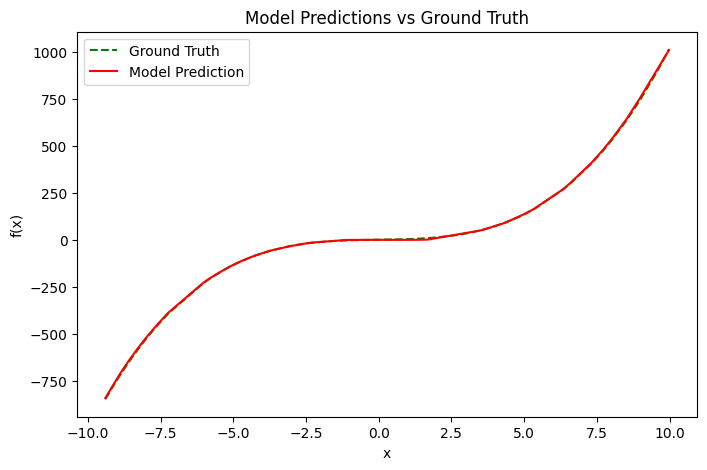

Mean Squared Error (MSE): 16.165529
Mean Absolute Error (MAE): 3.020424
R² Score: 0.999897

🔹 Training model with Activation: Tanh, Optimizer: RMSprop
Epoch 0 → Train Loss: 152913.609375, Val Loss: 136239.671875
Epoch 100 → Train Loss: 122099.210938, Val Loss: 110087.851562
Epoch 200 → Train Loss: 107109.750000, Val Loss: 96875.859375
Epoch 300 → Train Loss: 94716.320312, Val Loss: 85909.468750
Epoch 400 → Train Loss: 83770.070312, Val Loss: 76199.578125
Epoch 500 → Train Loss: 73914.796875, Val Loss: 67423.101562
Epoch 600 → Train Loss: 64995.218750, Val Loss: 59468.101562
Epoch 700 → Train Loss: 56919.644531, Val Loss: 52263.933594
Epoch 800 → Train Loss: 49620.675781, Val Loss: 45729.175781
Epoch 900 → Train Loss: 43044.136719, Val Loss: 39797.761719
Epoch 1000 → Train Loss: 37141.070312, Val Loss: 34418.820312
Epoch 1100 → Train Loss: 31866.613281, Val Loss: 29553.390625
Epoch 1200 → Train Loss: 27179.099609, Val Loss: 25171.695312
Epoch 1300 → Train Loss: 23042.369141, Val Loss: 2

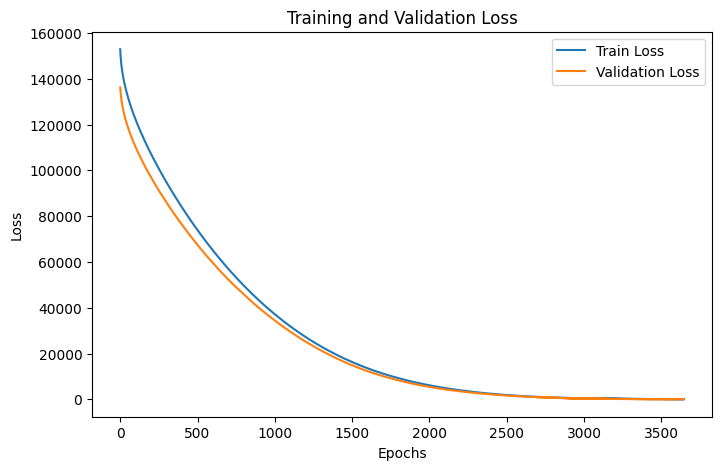

Mean Squared Error (MSE): 57.290871
Mean Absolute Error (MAE): 3.057033
R² Score: 0.999637

🔹 Training model with Activation: Sigmoid, Optimizer: RMSprop
Epoch 0 → Train Loss: 153011.593750, Val Loss: 137119.406250
Epoch 100 → Train Loss: 136768.984375, Val Loss: 123145.062500
Epoch 200 → Train Loss: 128351.679688, Val Loss: 115645.820312
Epoch 300 → Train Loss: 121016.929688, Val Loss: 109133.593750
Epoch 400 → Train Loss: 114218.703125, Val Loss: 103105.281250
Epoch 500 → Train Loss: 107786.062500, Val Loss: 97386.320312
Epoch 600 → Train Loss: 101666.968750, Val Loss: 91930.953125
Epoch 700 → Train Loss: 95834.382812, Val Loss: 86724.906250
Epoch 800 → Train Loss: 90266.617188, Val Loss: 81751.476562
Epoch 900 → Train Loss: 84953.781250, Val Loss: 77005.695312
Epoch 1000 → Train Loss: 79881.148438, Val Loss: 72471.132812
Epoch 1100 → Train Loss: 75043.703125, Val Loss: 68143.718750
Epoch 1200 → Train Loss: 70429.453125, Val Loss: 64015.753906
Epoch 1300 → Train Loss: 66032.390625, V

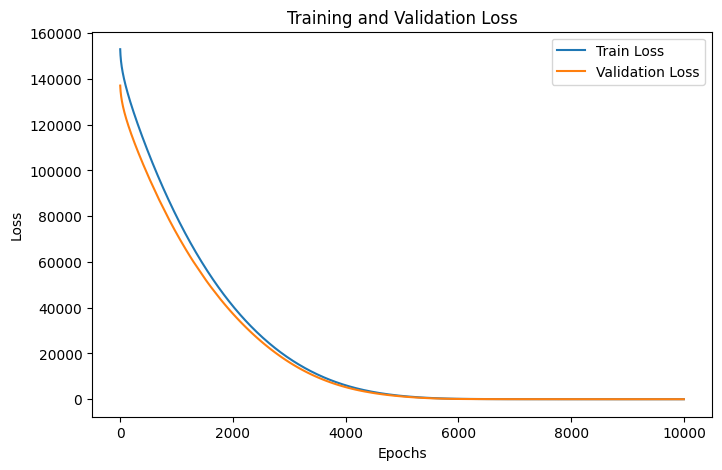

Mean Squared Error (MSE): 8.803320
Mean Absolute Error (MAE): 1.947071
R² Score: 0.999944

🔹 Training model with Activation: Leaky ReLU, Optimizer: RMSprop
Epoch 0 → Train Loss: 151513.796875, Val Loss: 132098.609375
Epoch 100 → Train Loss: 22812.175781, Val Loss: 22384.998047
Epoch 200 → Train Loss: 18669.539062, Val Loss: 18135.800781
Epoch 300 → Train Loss: 14188.287109, Val Loss: 13565.139648
Epoch 400 → Train Loss: 9841.847656, Val Loss: 9169.177734
Epoch 500 → Train Loss: 6343.237305, Val Loss: 5693.323242
Epoch 600 → Train Loss: 3919.000732, Val Loss: 3454.626953
Epoch 700 → Train Loss: 2381.405762, Val Loss: 2060.152832
Epoch 800 → Train Loss: 1445.165161, Val Loss: 1221.732544
Epoch 900 → Train Loss: 879.667419, Val Loss: 725.937134
Epoch 1000 → Train Loss: 527.452515, Val Loss: 446.133545
Epoch 1100 → Train Loss: 309.128357, Val Loss: 284.156830
Epoch 1200 → Train Loss: 180.711838, Val Loss: 187.931915
Epoch 1300 → Train Loss: 106.824318, Val Loss: 128.741333
Epoch 1400 → Tra

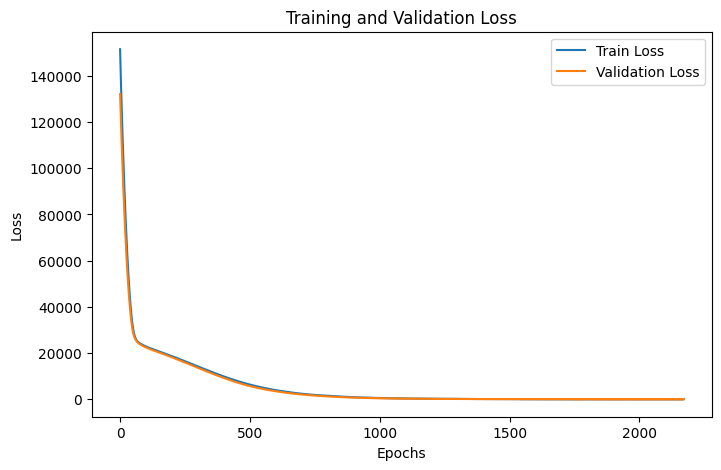

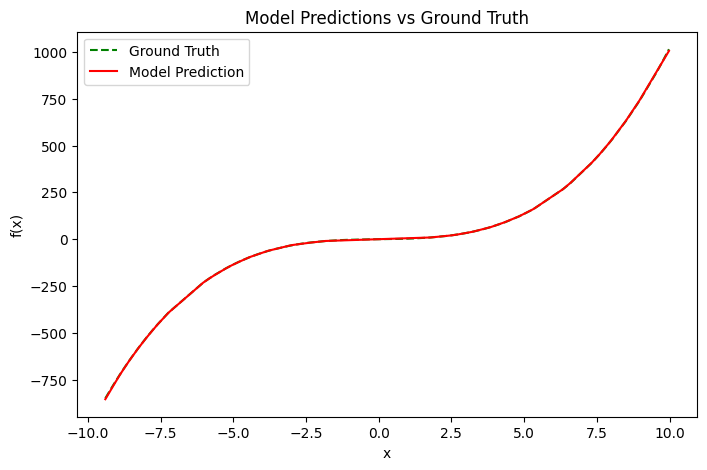

Mean Squared Error (MSE): 2.347515
Mean Absolute Error (MAE): 0.951631
R² Score: 0.999985


In [ ]:
import torch.nn.functional as F
import pandas as pd

# Fixed architecture for activation function and optimizer comparison
fixed_architecture2 = {"hidden_size": 32, "num_layers": 1}

# Define activation functions
activation_functions2 = {
    "ReLU": F.relu,
    "Tanh": torch.tanh,
    "Sigmoid": torch.sigmoid,
    "Leaky ReLU": F.leaky_relu
}


# Store results in a dataframe
results2_opt = []

# Function to run experiments
def start_complex_function(opt="Adam", epochs=10000, learning_rate=0.01, patience=50):
    """
    Trains the model with different activation functions and optimizers.
    """

    for act_name, act_func in activation_functions2.items():
        print(f"\n🔹 Training model with Activation: {act_name}, Optimizer: {opt}")

        # Create model with the given architecture and activation function
        model2_opt = FeedforwardNN(
            hidden_size=fixed_architecture2["hidden_size"],
            num_hidden_layers=fixed_architecture2["num_layers"],
            activation_fn=act_func
        )

        # Train model with specified optimizer, epochs, and learning rate
        loss_history, val_loss_history = train_model(
            model2_opt, X_train2, y_train2, X_val2, y_val2,
            epochs=epochs, patience=patience, optimizer_type=opt, learning_rate=learning_rate
        )

        # Plot predictions
        plot_predictions(model2_opt, X_test2, y_test2)
        plt.show()

        # Evaluate model performance
        mse, mae, r2 = evaluate_model(model2_opt, X_test2, y_test2)

        # Store results in a list
        results2_opt.append({
            "Activation Function": act_name,
            "Optimizer": opt,
            "Final Train Loss": loss_history[-1] if loss_history else None,
            "Final Val Loss": val_loss_history[-1] if val_loss_history else None,
            "MSE": mse,
            "MAE": mae,
            "R² Score": r2
        })

# Run experiments for different optimizers
start_complex_function(opt="Adam", learning_rate=0.01)
start_complex_function(opt="SGD", learning_rate=0.01)
start_complex_function(opt="RMSprop", learning_rate=0.01)

# Convert results to Pandas DataFrame
df_results2_opt = pd.DataFrame(results2_opt)

In [ ]:
# Display results table
df_results2_opt

Activation Function Optimizer  Final Train Loss  Final Val Loss        MSE  \
0                 ReLU      Adam          4.614431        6.073629   7.390763   
1                 Tanh      Adam          3.599792        1.869548   5.752917   
2              Sigmoid      Adam          0.944594        0.340757   1.655307   
3           Leaky ReLU      Adam          2.936468        2.640515   4.004737   
4                 ReLU       SGD          3.965951        3.759225   3.990638   
5                 Tanh       SGD          9.567807        7.135367  10.848844   
6              Sigmoid       SGD         12.295472        9.010462  13.616142   
7           Leaky ReLU       SGD          3.800204        3.594813   3.905761   
8                 ReLU   RMSprop         25.180857       18.594189  16.165529   
9                 Tanh   RMSprop         96.926712       40.136398  57.290871   
10             Sigmoid   RMSprop          8.626246        5.329681   8.803320   
11          Leaky ReLU   RMSprop         70.116493        2.042115   2.347515   

         MAE  R² Score  
0   1.512170  0.999953  
1   0.639231  0.999964  
2   0.355364  0.999990  
3   1.254813  0.999975  
4   1.344518  0.999975  
5   1.111343  0.999931  
6   1.060134  0.999914  
7   1.270278  0.999975  
8   3.020424  0.999897  
9   3.057033  0.999637  
10  1.947071  0.999944  
11  0.951631  0.999985